# Read output files

In [1]:
import awkward as ak
import numpy as np
import os, uproot, yaml
from glob import glob

In [4]:
source = 'trigger'
base = f'/data/bond/fudawei/public/bbgamma_output/{source}'

filepath = {
    year: {
        #r'Top+$\gamma$': [i for channel in ['TTGJets'] for i in glob(f'{base}/mc/{year}/{channel}/*')],
        #r'Z+$\gamma$': [i for channel in ['ZGToLLG', 'ZGToJJG'] for i in glob(f'{base}/mc/{year}/{channel}/*')],
        #r'W+$\gamma$': [i for channel in ['WGToJJG', 'WGToLNuG'] for i in glob(f'{base}/mc/{year}/{channel}/*')],
        #r'Non-prompt $\gamma$': [i for channel in ['ST', 'TTJets', 'ZJetsToNuNu', 'ZJetsToLL', 'ZJetsToQQ', 'WJetsToLNu', 'WJetsToQQ', 'QCD']  for i in glob(f'{base}/mc/{year}/{channel}/*')],
        #r'QCD+$\gamma$': [i for channel in ['GJets'] for i in glob(f'{base}/mc/{year}/{channel}/*')],
        'data': [i for channel in ["SingleMuon"] for i in glob(f'{base}/data/{year}/{channel}/*')],
    } for year in ['2016pre', '2016post', '2017', '2018']
}

BKG = set([k for k in filepath['2018'].keys()]) - set(['data'])

for year in filepath:
    for job_dir in [i for channel in ['ZpToHG'] for i in glob(f'{base}/mc/{year}/{channel}/*')]:
        mass = job_dir[-4:].replace('M', '').replace('_', '')
        filepath[year][mass+r'$\to$'+('H' if 'ZpToHG' in job_dir else 'Z')+r'$\gamma$'] = [job_dir]

events = {year: {k: [] for k in filepath[year]} for year in filepath}


for year in filepath:
    for channel, folders in filepath[year].items():
        for folder in folders:
            mode = '_'.join(folder.split('/')[-4:-1])
            if len(os.listdir(folder)) != 2:
                continue
            folder_events = ak.from_parquet(os.path.join(folder, f'{mode}.parq'))
            with open(os.path.join(folder, f'{mode}.yaml'), 'r', encoding='utf-8') as f:
                folder_stats = yaml.safe_load(f)
            if 'mc' in mode and ak.mean(folder_events.event_final_weight) > np.sqrt(folder_stats['final']):
                continue

            events[year][channel].append(folder_events)
        if len(events[year][channel]) == 0:
            del events[year][channel]
        else:
            events[year][channel] = ak.concatenate(events[year][channel], axis=0)
    #events[year]['bkg'] = ak.concatenate([events[year][c] for c in BKG], axis=0)

SIG_COLOR = {
    #r'700$\to$H(bb)$\gamma$': 'cyan',
    r'1000$\to$H(bb)$\gamma$': 'red',
    #r'1000$\to$Z(bb)$\gamma$': 'blue',
    #r'2000$\to$H(bb)$\gamma$': 'blue',
    #r'2000$\to$Z(bb)$\gamma$': 'cyan',
    r'3000$\to$H(bb)$\gamma$': 'yellow',
    #r'3000$\to$Z(bb)$\gamma$': 'BlueViolet',
}

## Decomposite signal

In [5]:
def decomposite(signal: ak.Array):
    HWW_decay_mode = ak.fill_none(signal.gen_HWW_decay_mode, 0)
    
    signal['HWW_4q'] = signal['gen_ZpToH(WW)Gamma'] & (HWW_decay_mode >= 32)
    
    signal['HWW_qqlv'] = signal['gen_ZpToH(WW)Gamma'] & (HWW_decay_mode > 16) & (HWW_decay_mode < 32)
    
    signal['HWW_lvlv'] = signal['gen_ZpToH(WW)Gamma'] & (HWW_decay_mode <= 16)
    
    return signal

DECOMPOSITE = True
if DECOMPOSITE:
    for y in events:
        for c in list(events[y].keys()):
            if c in BKG or c=='data':
                continue
            if 'H' in c:
                events[y][c.replace('H', 'H(bb)')] = events[y][c][events[y][c]['gen_ZpToH(bb)Gamma']]
            if 'Z' in c:
                events[y][c.replace('Z', 'Z(bb)')] = events[y][c][events[y][c]['gen_GluGluToZ(bb)Gamma']]


In [6]:
weight={
    y: {
        c: (events[y][c].event_final_weight if c!='data' else ak.ones_like(events[y][c]['photon_pt'])) for c in events[y] 
    } for y in events
}


weight['Run2'] = {k: ak.concatenate([weight[y][k] for y in weight if k in weight[y]], axis=0) for k in weight['2018']}
events['Run2'] = {k: ak.concatenate([events[y][k] for y in events if k in events[y]], axis=0) for k in events['2018']}


# Start plotting

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return np.abs(h), var

def error_bar(h, var, mode='data'):
    from scipy.interpolate import CubicSpline
    
    h, var = np.array(h), np.array(var)
    if mode == 'data':
        number = h
    elif mode == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = np.nan_to_num(h**2/var, nan=0)
    else:
        raise ValueError("mode should be 'data' or 'mc'! ")
    center = range(11)
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0) & (number<=10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])

    if mode == 'mc':
        up_error_bar *= np.nan_to_num(var/h, nan=1)
        down_error_bar *= np.nan_to_num(var/h, nan=1)

    return np.array([down_error_bar, up_error_bar])

# Uncertainty

In [10]:
tagger_Hbb = {y: {} for y in events}
for y in tagger_Hbb:
    for k in events[y]:
        tagger_Hbb[y][k] = events[y][k]['AK8jet_Xbb_tagger']

FieldNotFoundError: no field 'AK8jet_Xbb_tagger' in record with 14 fields

This error occurred while attempting to slice

    <Array [{nPhoton: 1, ...}, {...}, ..., {...}] type='13532 * {nPhoton: i...'>

with

    'AK8jet_Xbb_tagger'

In [4]:
from matplotlib.cm import get_cmap
from cycler import cycler

hep.style.use("CMS")
mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab10").colors)

def uncertainty_plot(arrays, weight, plot_name: str, x_name: str, year='2018', bins=None, bin_width=None, x_min=0, x_max=2000, overflow=True, underflow=False, log_y=False, x_axis=None, y_min=0.5, y_max=1.5):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))
    if bin_width is not None:
        bins = int((x_max-x_min)/bin_width)
        
    ## canvas initializing
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.08)
    ax, ax1 = f.add_subplot(gs[0]), f.add_subplot(gs[1])
    ax.grid(); ax1.grid()
    hep.cms.label(data=False, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')


    ## analyze
    individual = {'h': {}, 'var': {}}
    
    for (k, v) in arrays.items():
        if x_axis is None:
            hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        else:
            hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
        
        if weight is not None:
            hist.fill(v, weight=weight[k])
        else:
            hist.fill(v)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        individual['h'][k] = h
        individual['var'][k] = var

    ## plot
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    #COLOR = {'nominal': 'blue', 'up': 'red', 'down': 'green'}
    err_nominal = error_bar(individual['h']['nominal'], individual['var']['nominal'], mode='mc')
    h_nominal = individual['h']['nominal']
    for (k, h) in individual['h'].items():
        if k == 'nominal':
            continue
        err = error_bar(h, individual['var'][k], mode='mc')
        hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=f'{k}: %.3f'%(np.sum(h)/np.sum(h_nominal)), histtype='step', density=False, stack=False, linewidth=2, ax=ax)
        ratio = h / individual['h']['nominal']
        ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
        hep.histplot(ratio, bins=hist.axes[0].edges, yerr=ratio_err, histtype='errorbar', density=False, stack=False, ax=ax1)
    hep.histplot(h_nominal, bins=hist.axes[0].edges, yerr=err_nominal, label='nominal: 1', histtype='step', density=False, stack=False, linewidth=2, ax=ax)


    ## axises
    ax.set_xlim(x_min, x_max)
    # ax.set_xticklabels([])
    ax.set_ylim(1e-3 if log_y else 0, ax.get_ylim()[1]*(3e2 if log_y else 1.2))
    if log_y:
        ax.set_yscale('log')
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    # x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    # y_major_locator=MultipleLocator(1)
    # ax.xaxis.set_major_locator(x_major_locator)
    # ax.yaxis.set_major_locator(y_major_locator)
    ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax1.set_ylim(y_min, y_max)
    ax1.set_ylabel('ratio', ha='center', fontsize=20)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)

    ## title, text and legend
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=15)

    ## finalizing
    if not os.path.exists(f'./plots/{year}'):
        os.makedirs(f'./plots/{year}')
    plt.savefig(f"./plots/{year}/{plot_name}.pdf", bbox_inches='tight')

NameError: name 'hep' is not defined

### L1 prefiring

/tmp/ipykernel_745545/2098487461.py:32: RuntimeWarning: invalid value encountered in true_divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_745545/2098487461.py:49: RuntimeWarning: invalid value encountered in true_divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_745545/2098487461.py:50: RuntimeWarning: invalid value encountered in true_divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_745545/3980180499.py:49: RuntimeWarning: invalid value encountered in true_divide
  ratio = h / individual['h']['nominal']
/tmp/ipykernel_745545/3980180499.py:50: RuntimeWarning: invalid value encountered in true_divide
  ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
/tmp/ipykernel_745545/2098487461.py:32: RuntimeWarning: invalid value encountered in true_divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_745545/2098487461.py:49: RuntimeWarning: invalid value encountered in true_divide
  up_error_bar

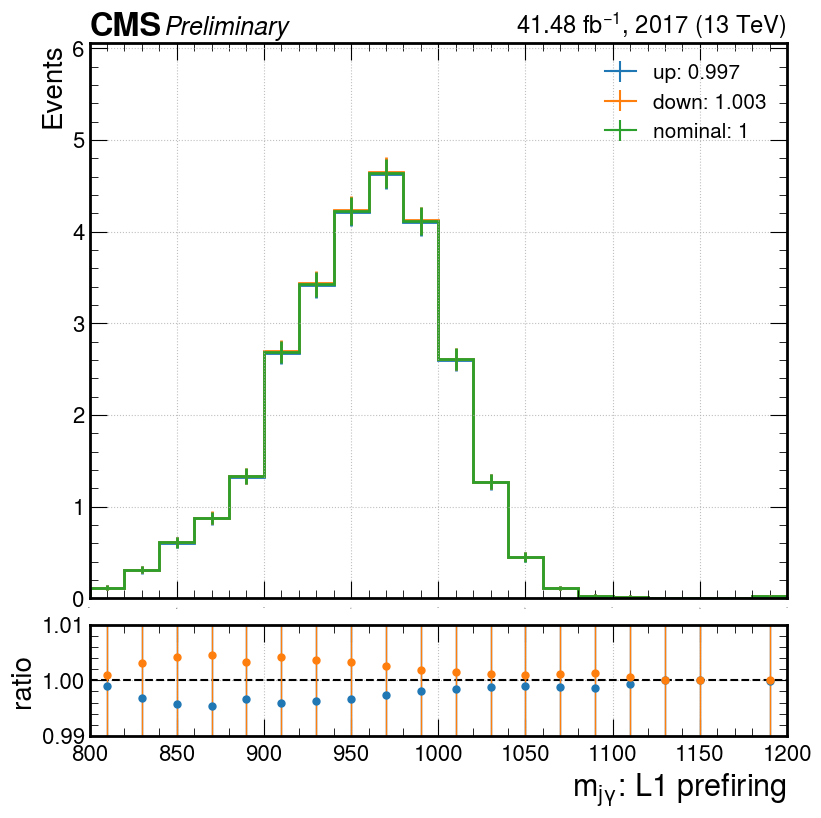

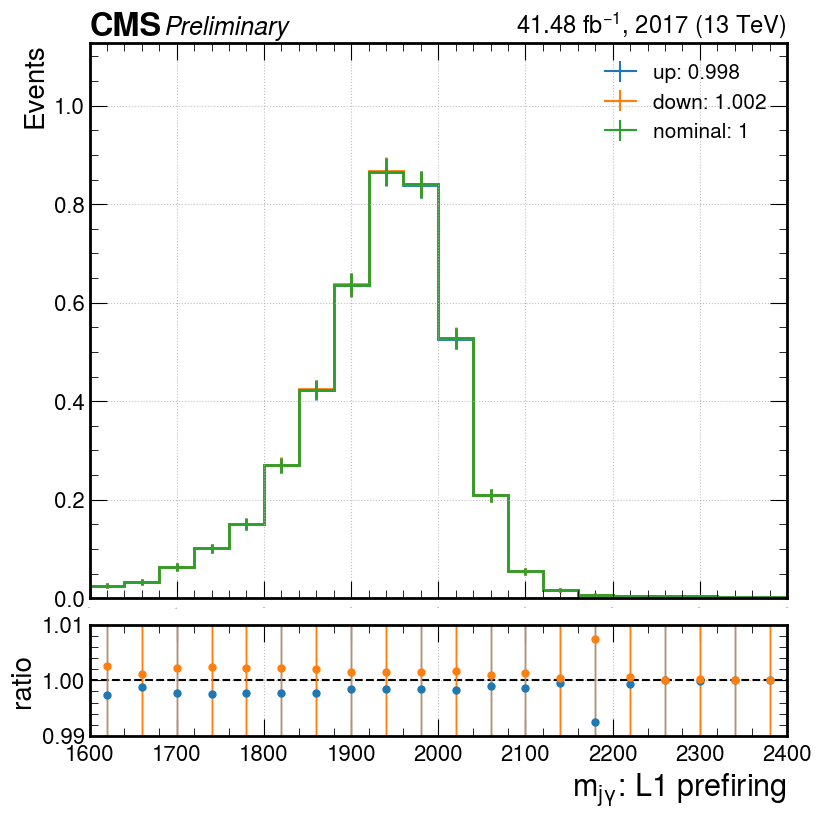

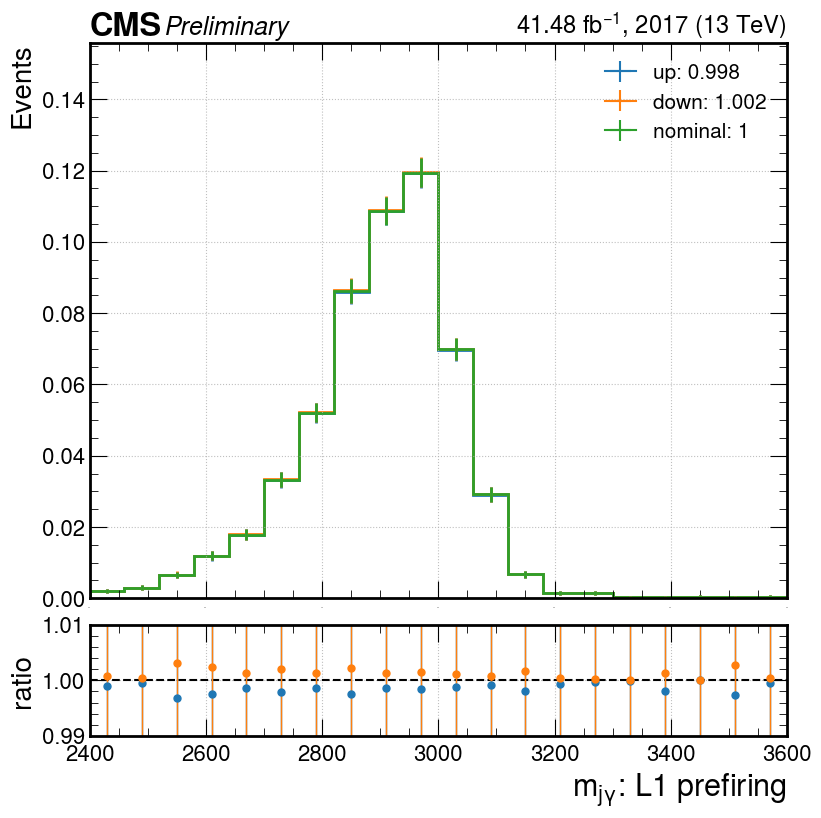

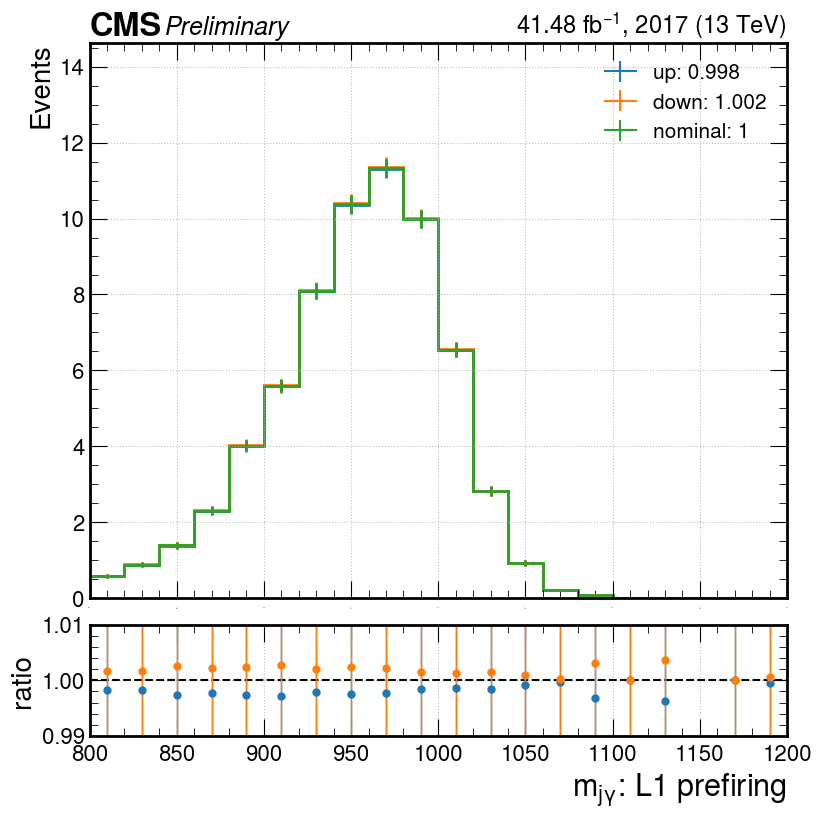

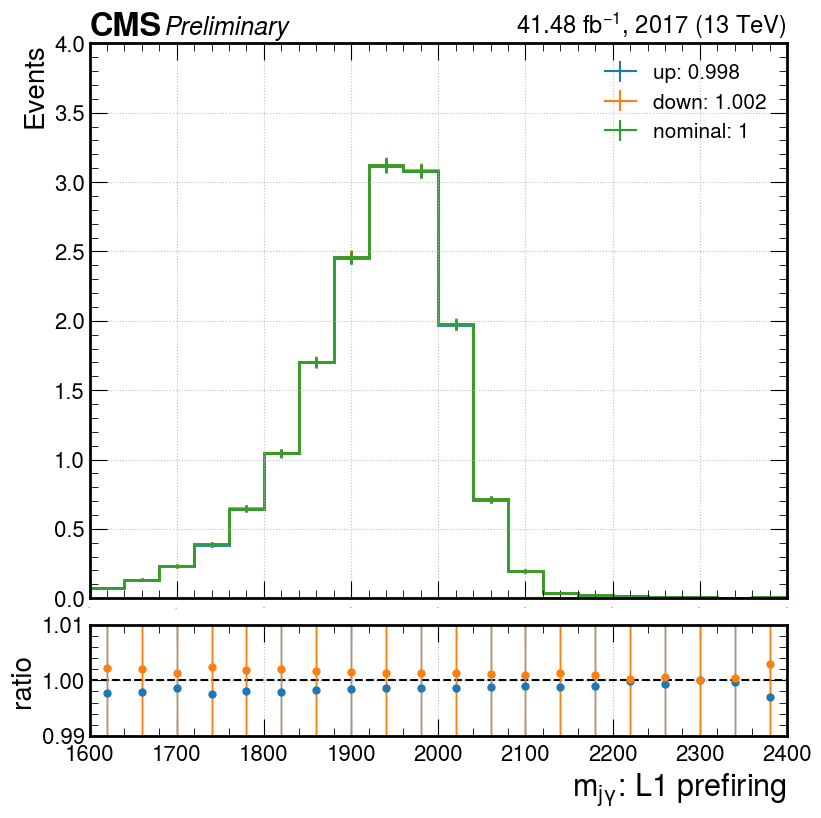

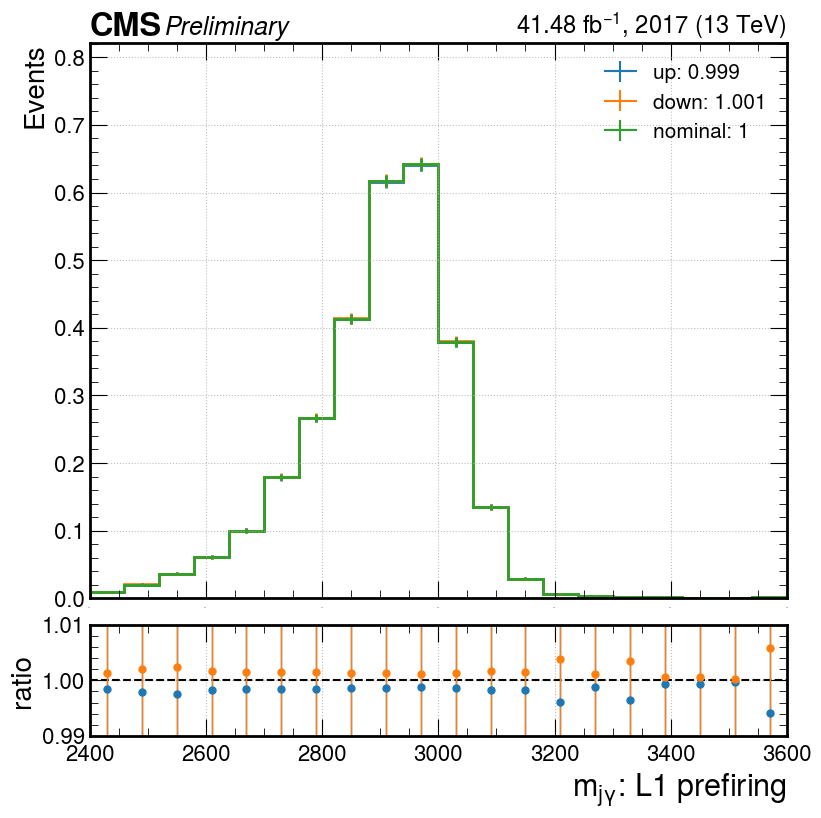

In [19]:
y='2017'
for k in SIG_COLOR:
    m = k[:4]
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (tagger_Hbb[y][k]>0.7) & 
        (tagger_Hbb[y][k]<0.9) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 145)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['L1PreFiringWeight_Up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['L1PreFiringWeight_Nom'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['L1PreFiringWeight_Dn'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'L1_m{m}_SR1', x_min=0.8*int(m), x_max=1.2*int(m), bins=20, weight=_weight, year=y, y_min=0.99, y_max=1.01)

for k in SIG_COLOR:
    m = k[:4]
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (tagger_Hbb[y][k]>0.9) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 145)
    )"""
    
    
    _weight = {
        'up': (weight[y][k]*events[y][k]['L1PreFiringWeight_Up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['L1PreFiringWeight_Nom'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['L1PreFiringWeight_Dn'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'L1_m{m}_SR2', x_min=0.8*int(m), x_max=1.2*int(m), bins=20, weight=_weight, year=y, y_min=0.99, y_max=1.01)

## Photon ID SF

In [25]:
from matplotlib.cm import get_cmap
from cycler import cycler

hep.style.use("CMS")
mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab10").colors)

def SF_plot(arrays, weight, plot_name: str, x_name: str, year='2018', bins=None, bin_width=None, x_min=0, x_max=2000, overflow=True, underflow=False, log_y=False, x_axis=None, y_min=0.5, y_max=1.5):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))
    if bin_width is not None:
        bins = int((x_max-x_min) / bin_width)
        
    ## canvas initializing
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(1, 1)
    ax = f.add_subplot(gs[0])
    ax.grid()
    hep.cms.label(data=False, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')


    ## analyze
    individual = {'h': {}, 'var': {}, 'err': {}}
    
    for (k, v) in arrays.items():
        if x_axis is None:
            hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        else:
            hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        
        if weight is not None:
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        individual['h'][k] = h
        individual['var'][k] = var
        individual['err'][k] = error_bar(individual['h'][k], individual['var'][k], mode='mc')

    ## plot
    ax.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')

    ratio = {}
    for (k, h) in individual['h'].items():
        if 'w/o' not in k:
            ratio[k] = individual['h'][k] / individual['h']['w/o SF']
    SF = np.sum(individual['h']['SF_nominal'])/np.sum(individual['h']['w/o SF'])

    k = 'photon ID SF'
    hep.histplot(ratio['SF_nominal'], bins=hist.axes[0].edges, yerr=[ratio['SF_nominal']-ratio['SF_down'], ratio['SF_up']-ratio['SF_nominal']], histtype='errorbar', density=False, stack=False, ax=ax, label=f'{k}: %.3f'%SF)

    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax.set_ylim(y_min, y_max)
    ax.set_ylabel('ratio', ha='right', fontsize=20, y=1)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax.tick_params(axis='both', which='major', labelsize=16)

    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=15)
    # plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')

    ## finalizing
    if not os.path.exists(f'./plots/{year}'):
        os.makedirs(f'./plots/{year}')
    plt.savefig(f"./plots/{year}/{plot_name}.pdf", bbox_inches='tight')

/tmp/ipykernel_954402/2995132637.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab10").colors)


/tmp/ipykernel_954402/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_954402/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_954402/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_954402/2995132637.py:46: RuntimeWarning: invalid value encountered in divide
  ratio[k] = individual['h'][k] / individual['h']['w/o SF']
/tmp/ipykernel_954402/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_954402/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_954402/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_954402/29

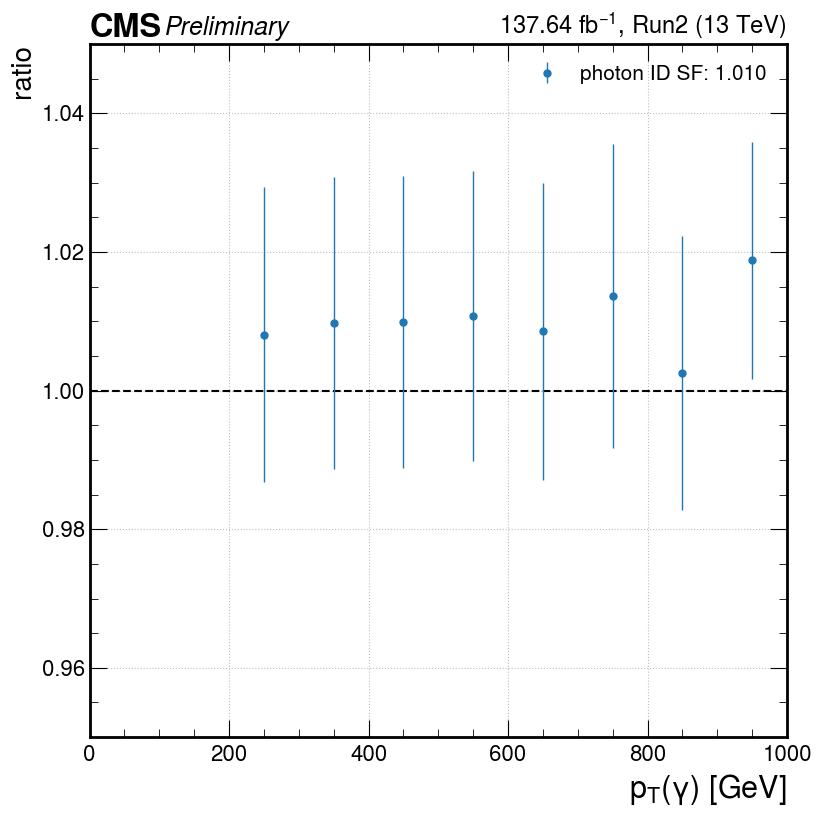

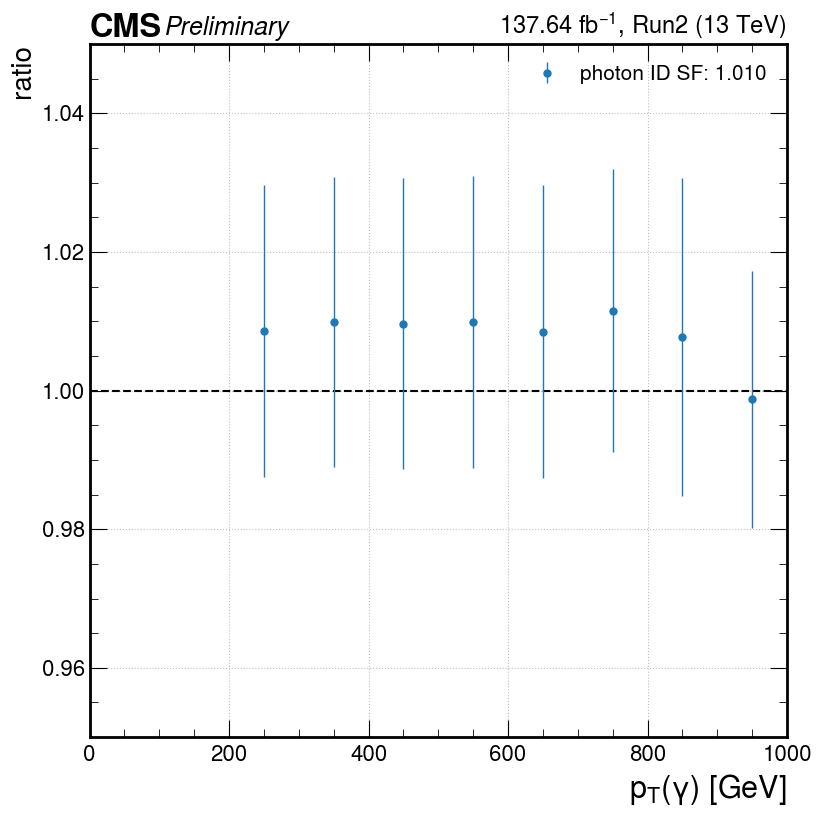

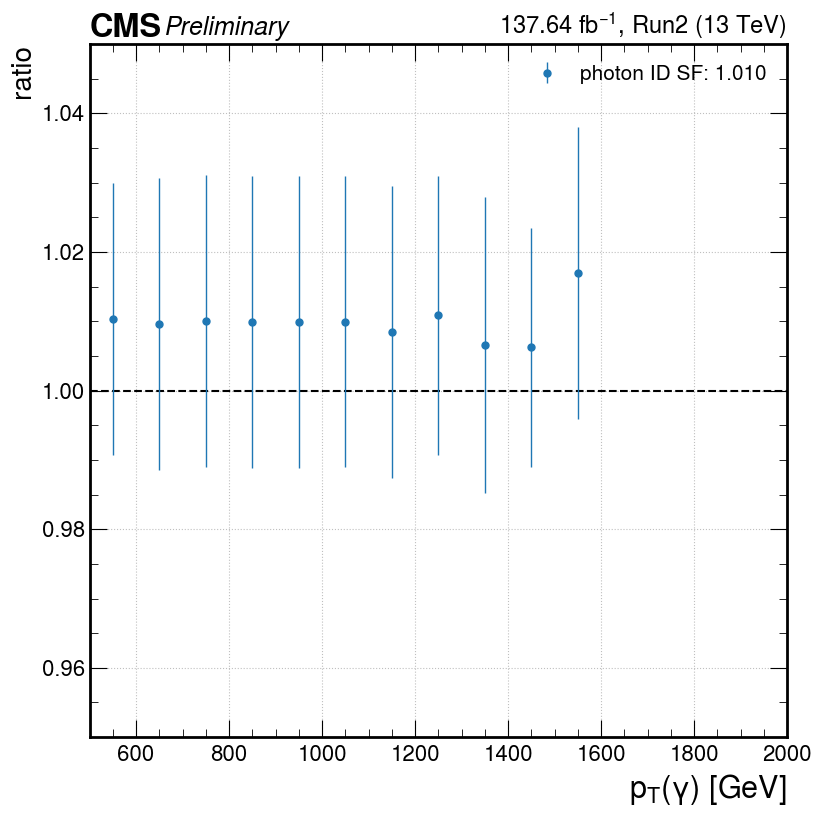

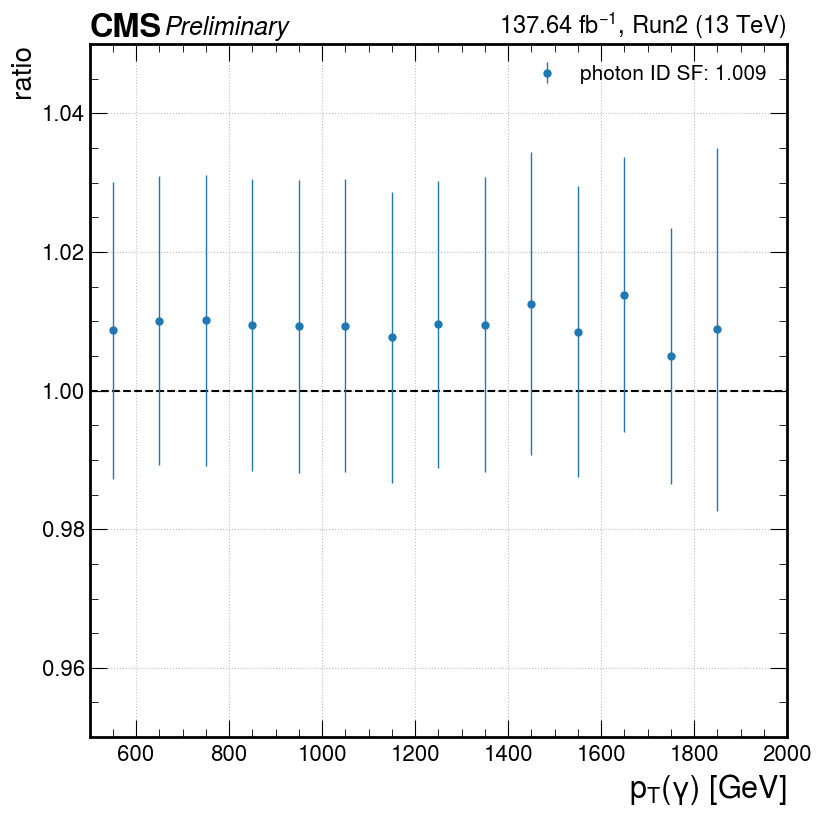

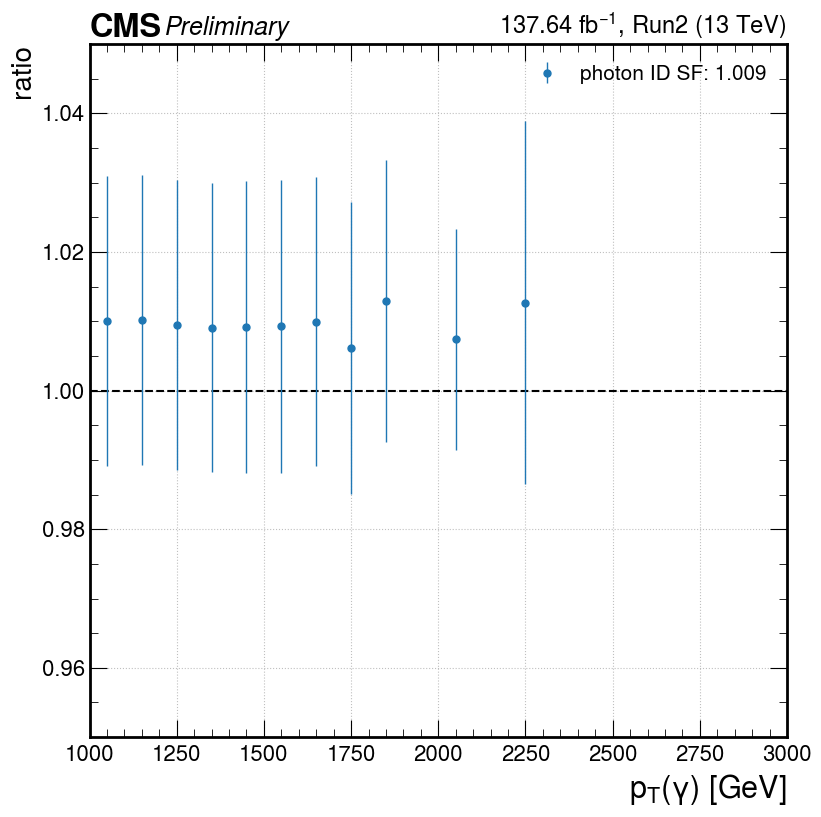

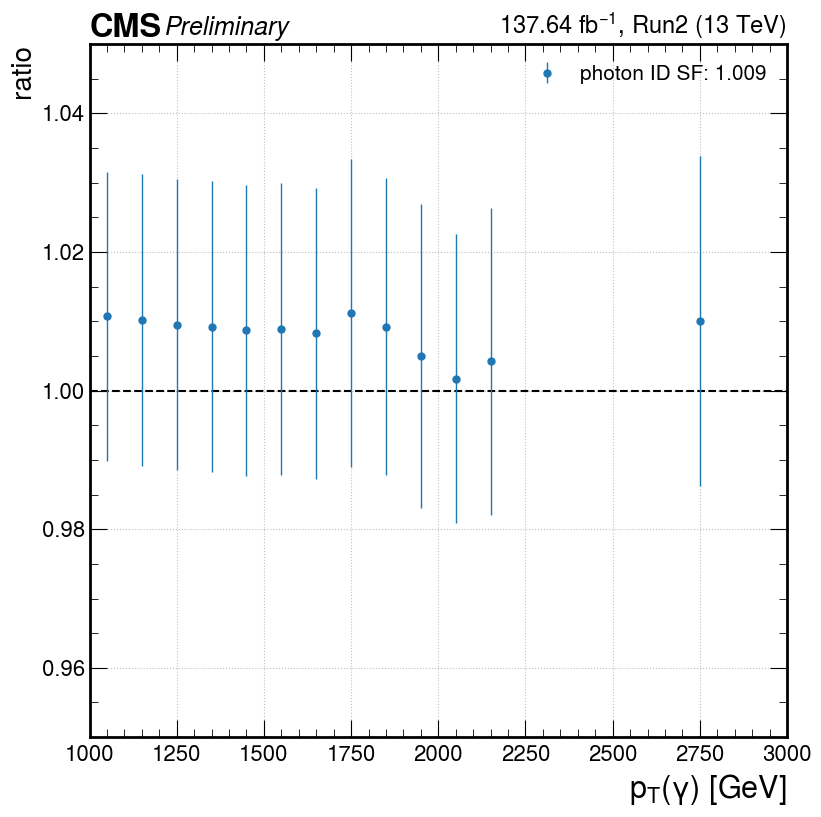

In [26]:
y='Run2'
for m in ('1000', '2000', '3000'):
    k=r'$Z^\mathrm{\prime}$('+ m + r')$\to H(bb)\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (tagger_Hbb[y][k]>0.8) & 
        (tagger_Hbb[y][k]<0.96) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] > 105) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] < 145)
    )"""
    _weight = {
        'SF_nominal': events[y][k]['photon_SF_nominal'][eval(cut)],
        'SF_up': events[y][k]['photon_SF_up'][eval(cut)],
        'SF_down': events[y][k]['photon_SF_down'][eval(cut)],
        'w/o SF': ak.ones_like(events[y][k]['photon_SF_nominal'][eval(cut)]),
    }
    arrays={
        i: events[y][k]['photon_pt'][eval(cut)] for i in _weight
    }
    SF_plot(arrays, x_name=r'$p_T(\gamma)$ [GeV]', plot_name=f'photon_SF_m{m}_SR1', x_min=int(m)/2-500, x_max=int(m), bin_width=100, weight=_weight, year=y, y_min=0.95, y_max=1.05)
    
    k=r'$Z^\mathrm{\prime}$('+ m + r')$\to H(bb)\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (tagger_Hbb[y][k]>0.96) &
        (events[y][k]['AK8jet_inclParTMDV1_mass'] > 105) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] < 145)
    )"""
    _weight = {
        'SF_nominal': events[y][k]['photon_SF_nominal'][eval(cut)],
        'SF_up': events[y][k]['photon_SF_up'][eval(cut)],
        'SF_down': events[y][k]['photon_SF_down'][eval(cut)],
        'w/o SF': ak.ones_like(events[y][k]['photon_SF_nominal'][eval(cut)]),
    }
    arrays={
        i: events[y][k]['photon_pt'][eval(cut)] for i in _weight
    }
    SF_plot(arrays, x_name=r'$p_T(\gamma)$ [GeV]', plot_name=f'photon_SF_m{m}_SR2', x_min=int(m)/2-500, x_max=int(m), bin_width=100, weight=_weight, year=y, y_min=0.95, y_max=1.05)

### uncertainty

/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/1920557526.py:53: RuntimeWarning: invalid value encountered in divide
  ratio = h / individual['h']['nominal']
/tmp/ipykernel_4038097/1920557526.py:54: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan

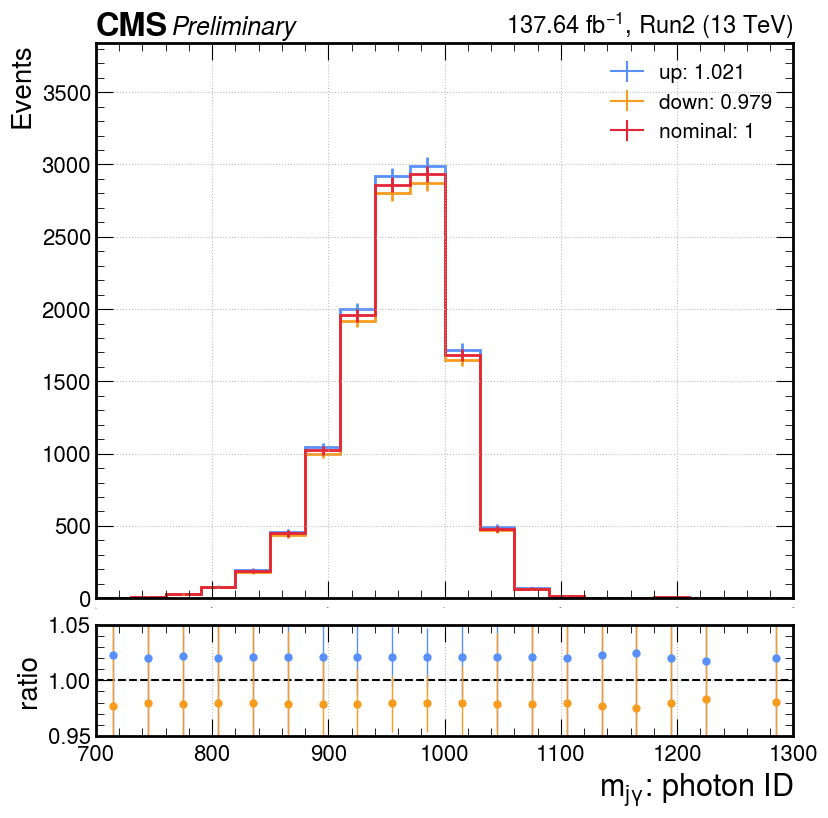

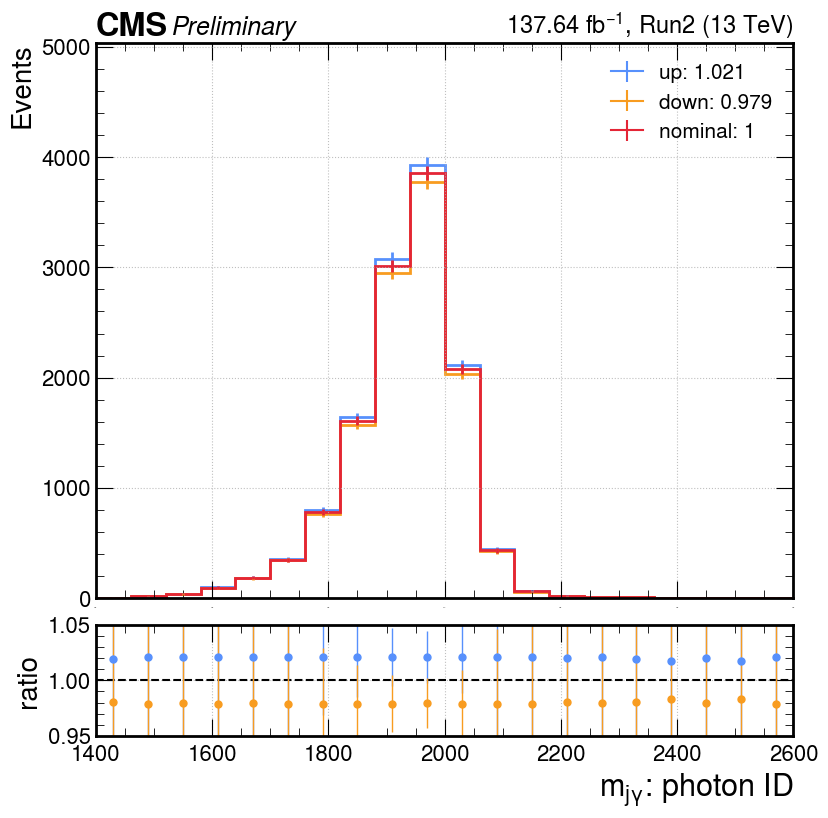

/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/1920557526.py:53: RuntimeWarning: invalid value encountered in divide
  ratio = h / individual['h']['nominal']
/tmp/ipykernel_4038097/1920557526.py:54: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan

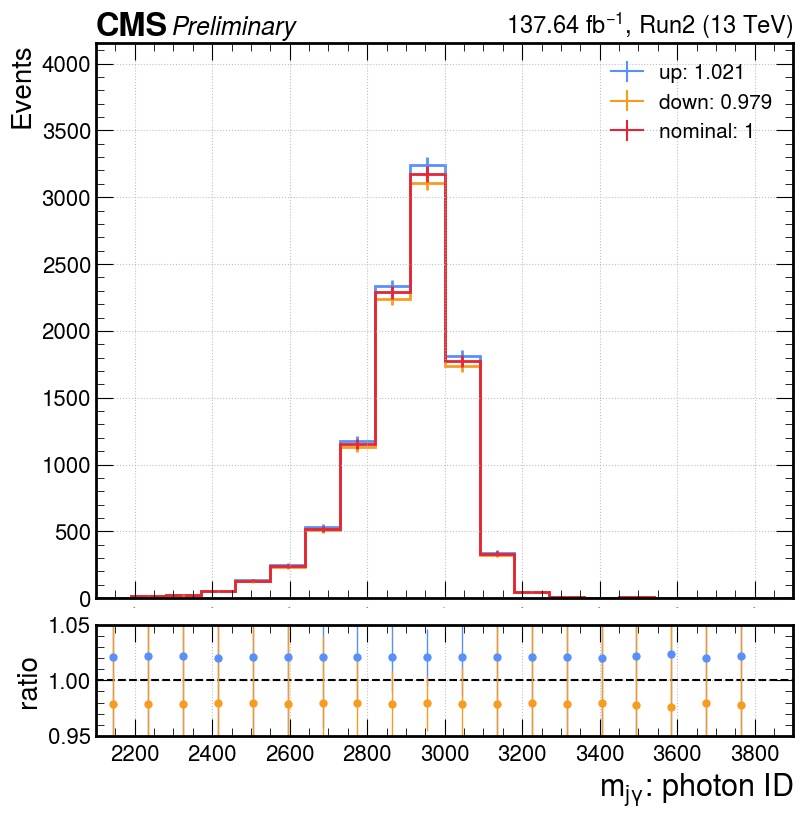

/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/1920557526.py:53: RuntimeWarning: invalid value encountered in divide
  ratio = h / individual['h']['nominal']
/tmp/ipykernel_4038097/1920557526.py:54: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan

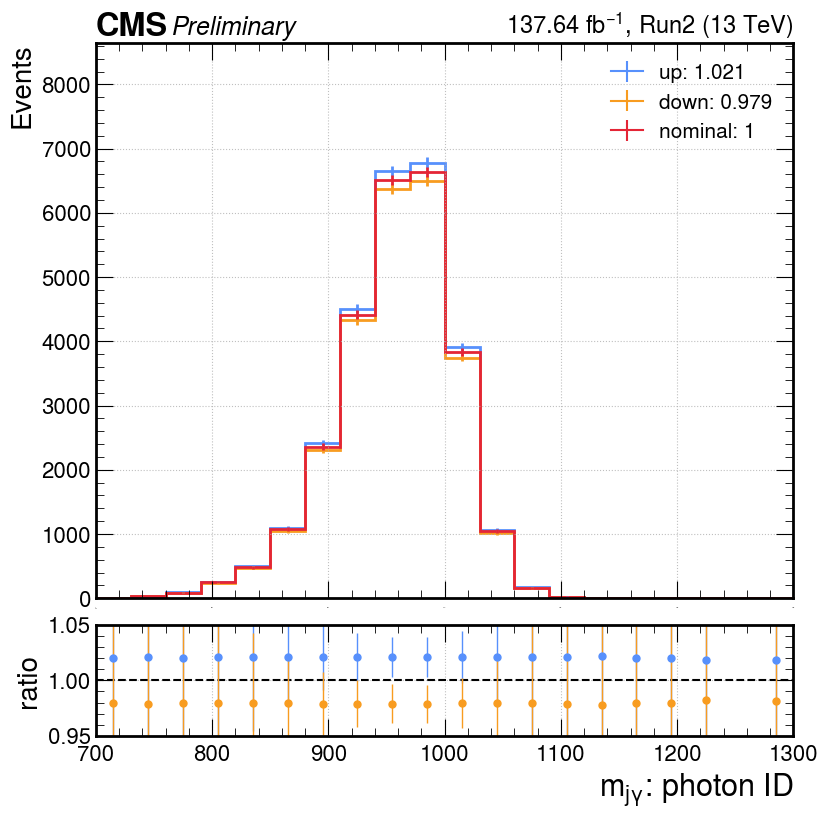

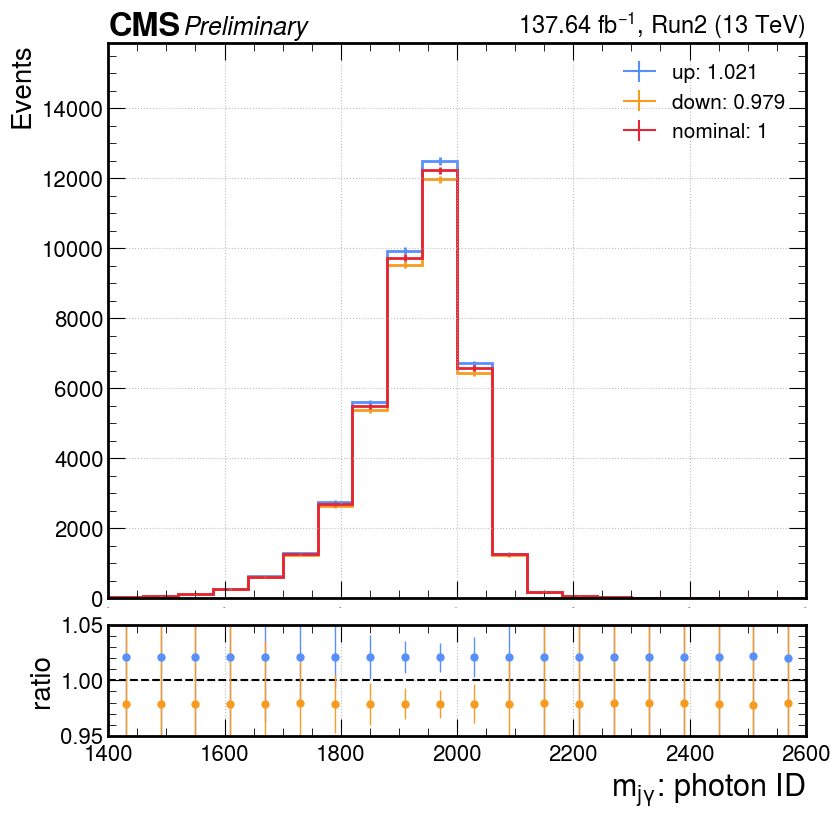

/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/1920557526.py:53: RuntimeWarning: invalid value encountered in divide
  ratio = h / individual['h']['nominal']
/tmp/ipykernel_4038097/1920557526.py:54: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan

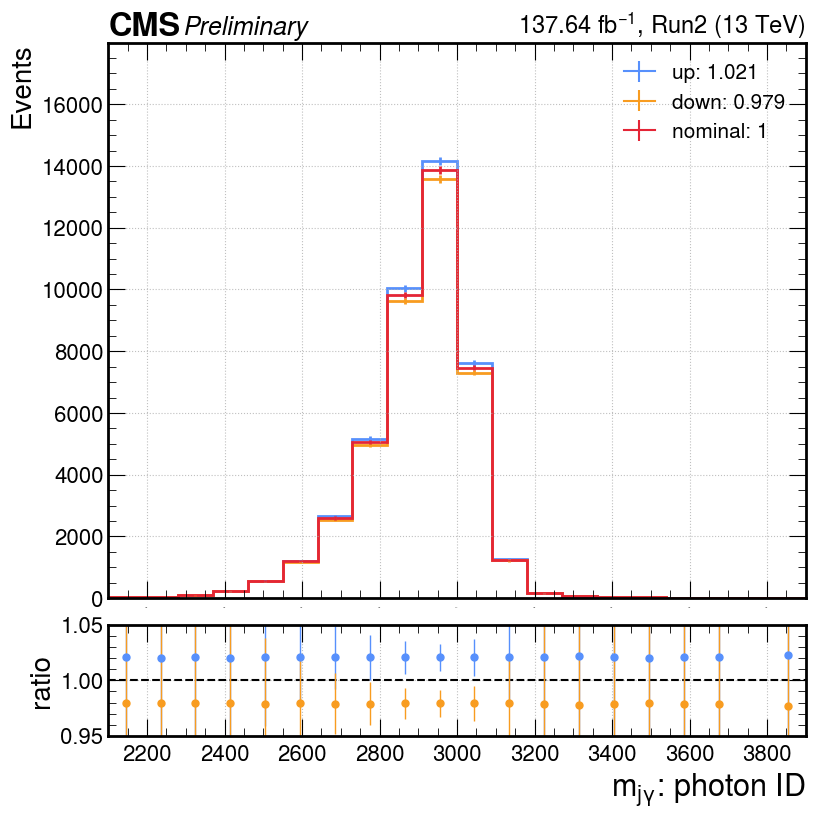

In [8]:
y='Run2'
for m in ('1000', '2000', '3000'):
    k=r'$Z^\mathrm{\prime}$('+ m + r')$\to H(bb)\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (tagger_Hbb[y][k]>0.7) & 
        (tagger_Hbb[y][k]<0.9) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] > 110) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] < 145)
    )"""
    _weight = {
        'up': events[y][k]['photon_SF_up'][eval(cut)],
        'nominal': events[y][k]['photon_SF_nominal'][eval(cut)],
        'down': events[y][k]['photon_SF_down'][eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: photon ID', plot_name=f'photon_ID_m{m}_SR1', x_min=int(m)*0.7, x_max=int(m)*1.3, bins=20, weight=_weight, year=y, y_min=0.95, y_max=1.05)
    
y='Run2'
for m in ('1000', '2000', '3000'):
    k=r'$Z^\mathrm{\prime}$('+ m + r')$\to H(bb)\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (tagger_Hbb[y][k]>0.9) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] > 110) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] < 145)
    )"""
    
    
    _weight = {
        'up': events[y][k]['photon_SF_up'][eval(cut)],
        'nominal': events[y][k]['photon_SF_nominal'][eval(cut)],
        'down': events[y][k]['photon_SF_down'][eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: photon ID', plot_name=f'photon_ID_m{m}_SR2', x_min=int(m)*0.7, x_max=int(m)*1.3, bins=20, weight=_weight, year=y, y_min=0.95, y_max=1.05)

## JES & JER

/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/1920557526.py:53: RuntimeWarning: invalid value encountered in divide
  ratio = h / individual['h']['nominal']
/tmp/ipykernel_4038097/1920557526.py:54: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan

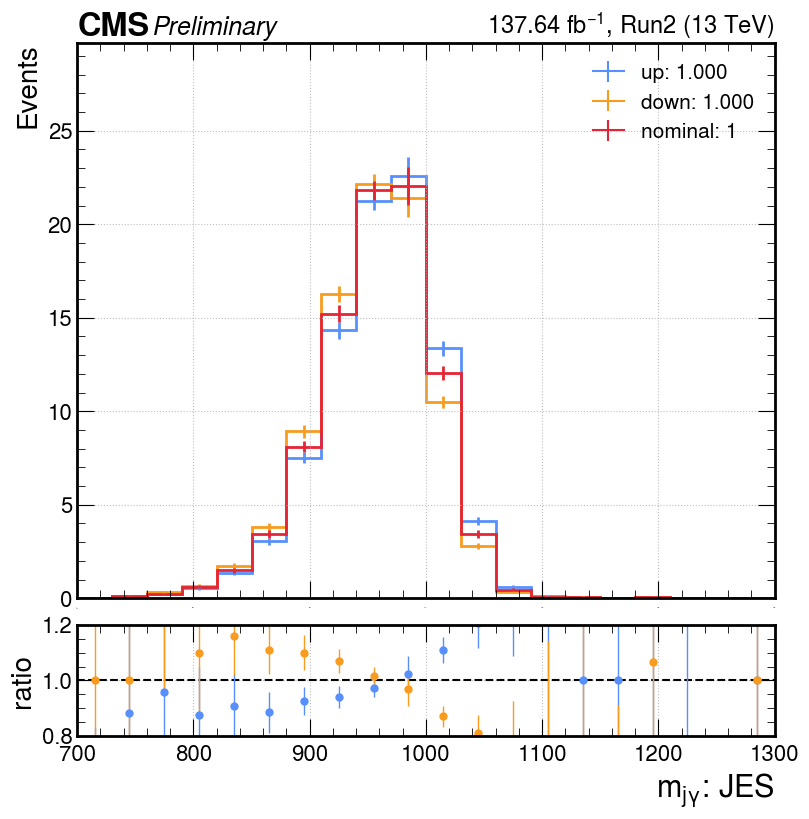

/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/1920557526.py:53: RuntimeWarning: invalid value encountered in divide
  ratio = h / individual['h']['nominal']
/tmp/ipykernel_4038097/1920557526.py:54: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
/tmp/ipykernel_4038097/1920557526.py:53: RuntimeWarning: divide by zero encountered in divide
  ratio = h / individual['h']['nominal']
/tmp/ipykernel_4038097/1920557526.py:54: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((err/h)**2 +

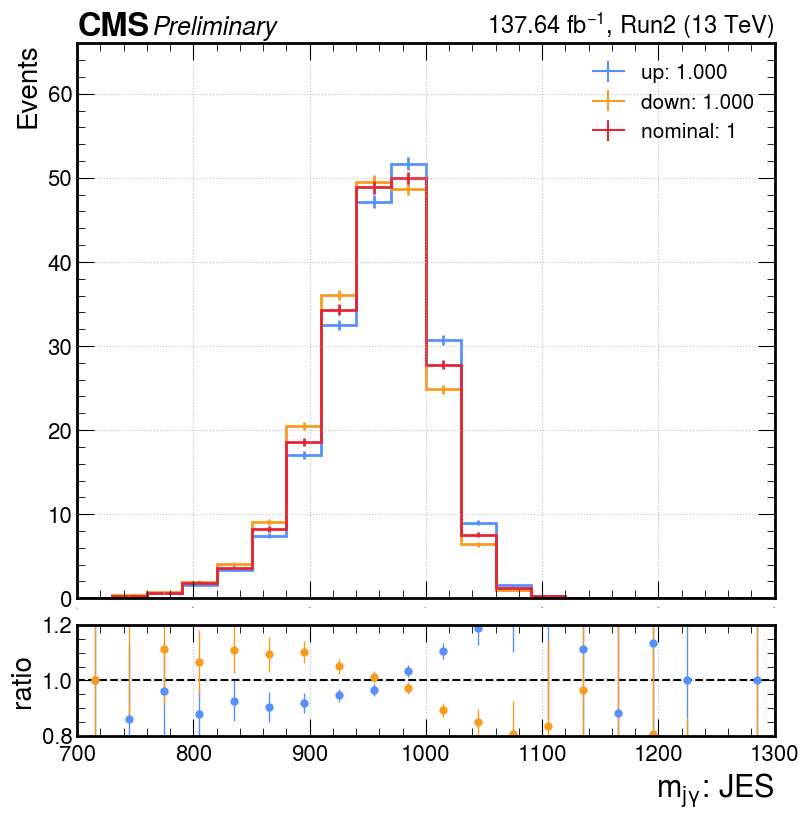

/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/1920557526.py:54: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var

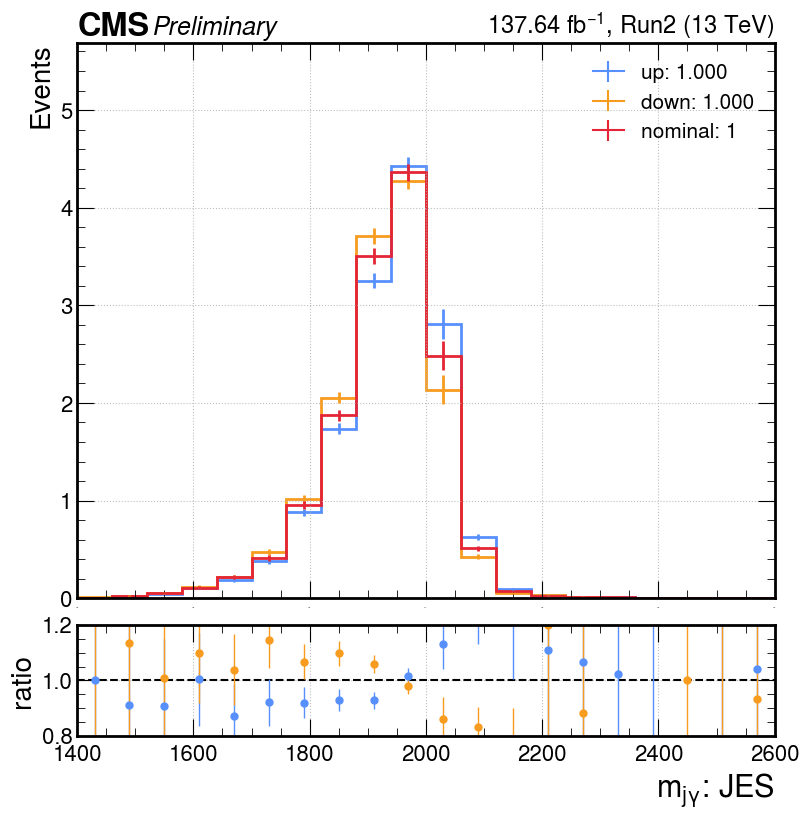

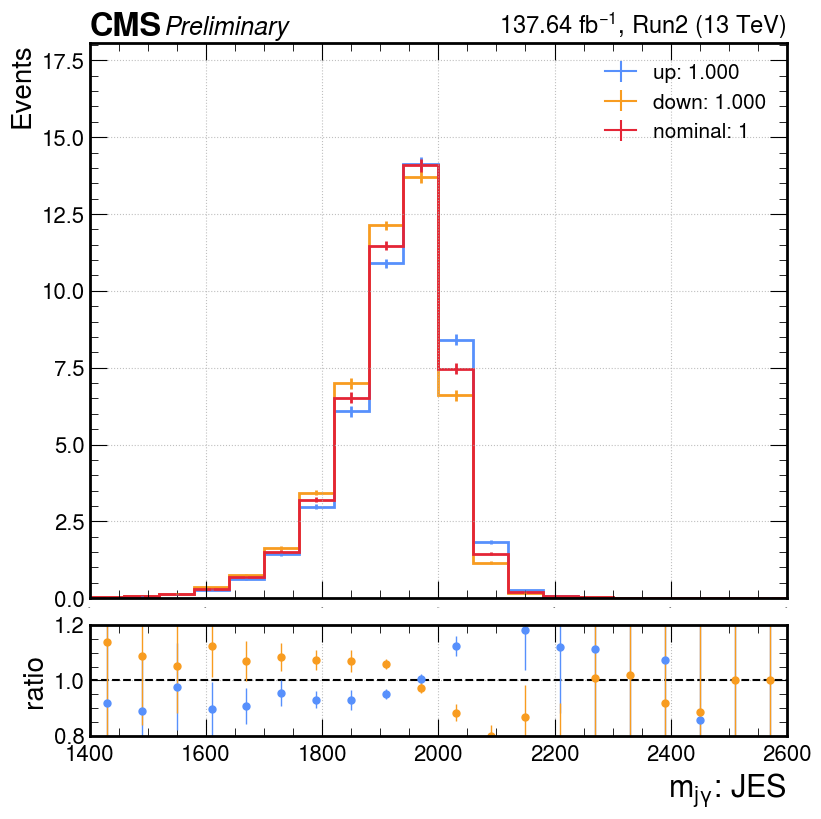

/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/1920557526.py:53: RuntimeWarning: invalid value encountered in divide
  ratio = h / individual['h']['nominal']
/tmp/ipykernel_4038097/1920557526.py:54: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan

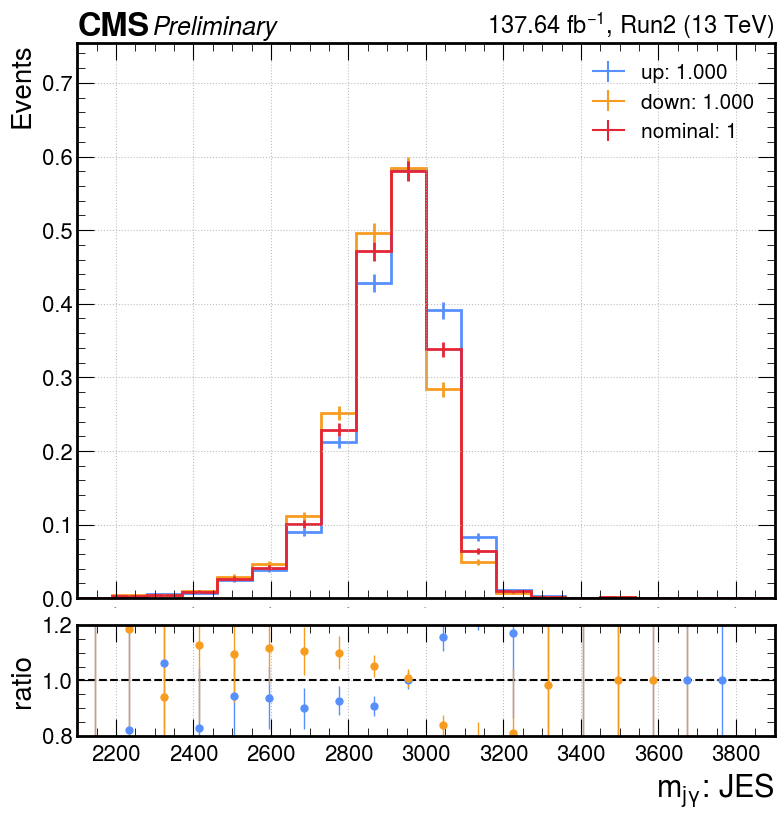

/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/1920557526.py:53: RuntimeWarning: divide by zero encountered in divide
  ratio = h / individual['h']['nominal']
/tmp/ipykernel_4038097/1920557526.py:54: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, na

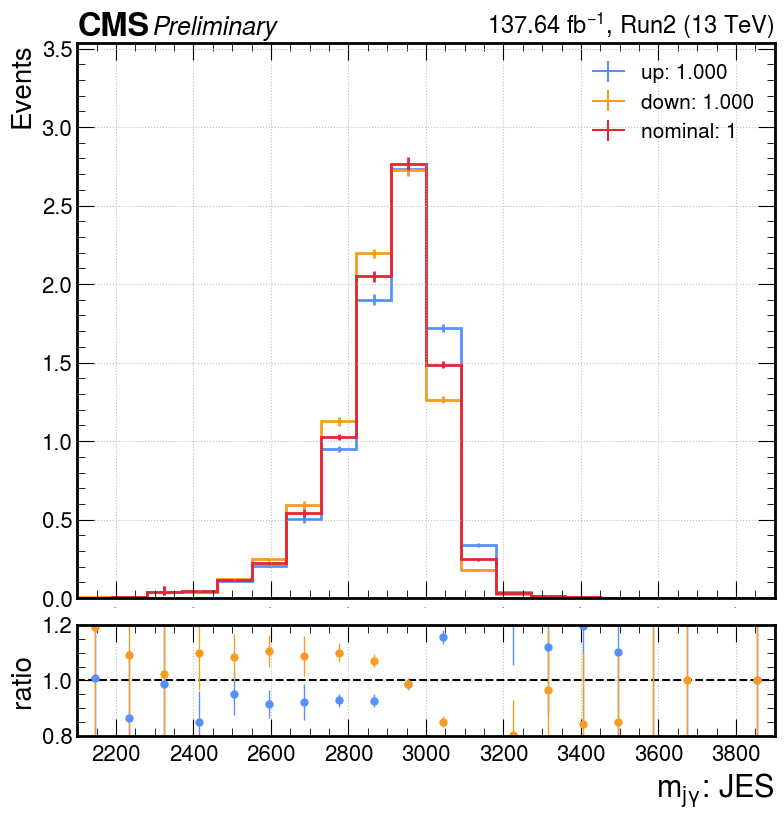

In [9]:
y='Run2'
for m in ('1000', '2000', '3000'):
    k=r'$Z^\mathrm{\prime}$('+ m + r')$\to H(bb)\gamma$'
    # SR1
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (tagger_Hbb[y][k]>0.7) & 
        (tagger_Hbb[y][k]<0.9) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] > 110) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] < 145)
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JES_jes_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JES_jes_down'][eval(cut)]
    }
    _weight = {
        i: weight[y][k][eval(cut)] for i in arrays.keys()
    }
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: JES', plot_name=f'JES_mass_m{m}_SR1', x_min=int(m)*0.7, x_max=int(m)*1.3, bins=20, weight=_weight, year=y, y_min=0.8, y_max=1.2)

    # SR2
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (tagger_Hbb[y][k]>0.9) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] > 110) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] < 145)
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JES_jes_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JES_jes_down'][eval(cut)]
    }
    _weight = {
        i: weight[y][k][eval(cut)] for i in arrays.keys()
    }
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: JES', plot_name=f'JES_mass_m{m}_SR2', x_min=int(m)*0.7, x_max=int(m)*1.3, bins=20, weight=_weight, year=y, y_min=0.8, y_max=1.2)

/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/1920557526.py:53: RuntimeWarning: invalid value encountered in divide
  ratio = h / individual['h']['nominal']
/tmp/ipykernel_4038097/1920557526.py:54: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan

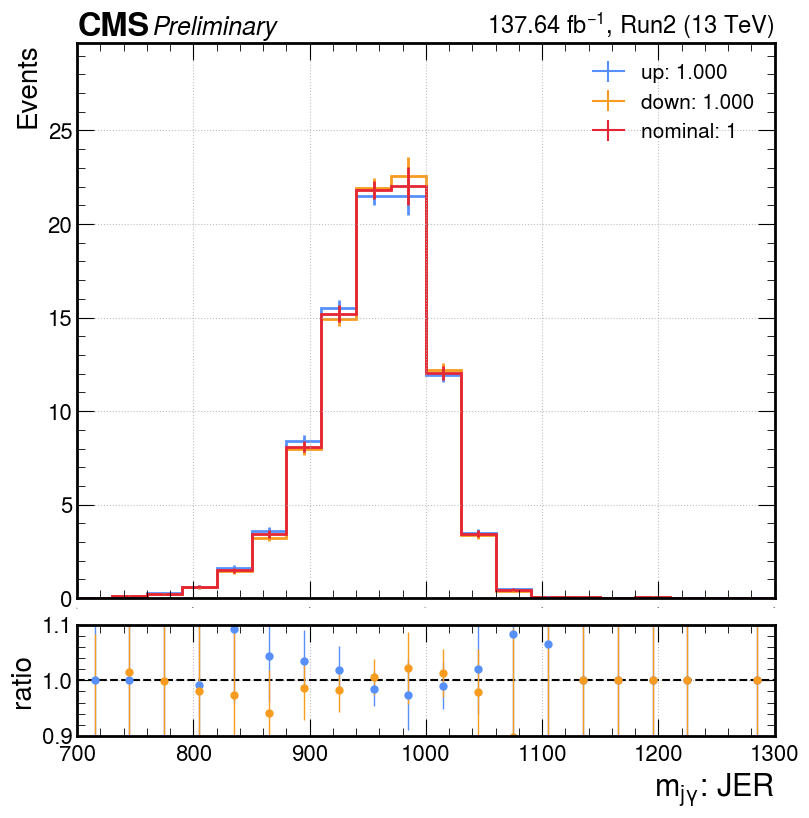

/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/1920557526.py:53: RuntimeWarning: divide by zero encountered in divide
  ratio = h / individual['h']['nominal']
/tmp/ipykernel_4038097/1920557526.py:54: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, na

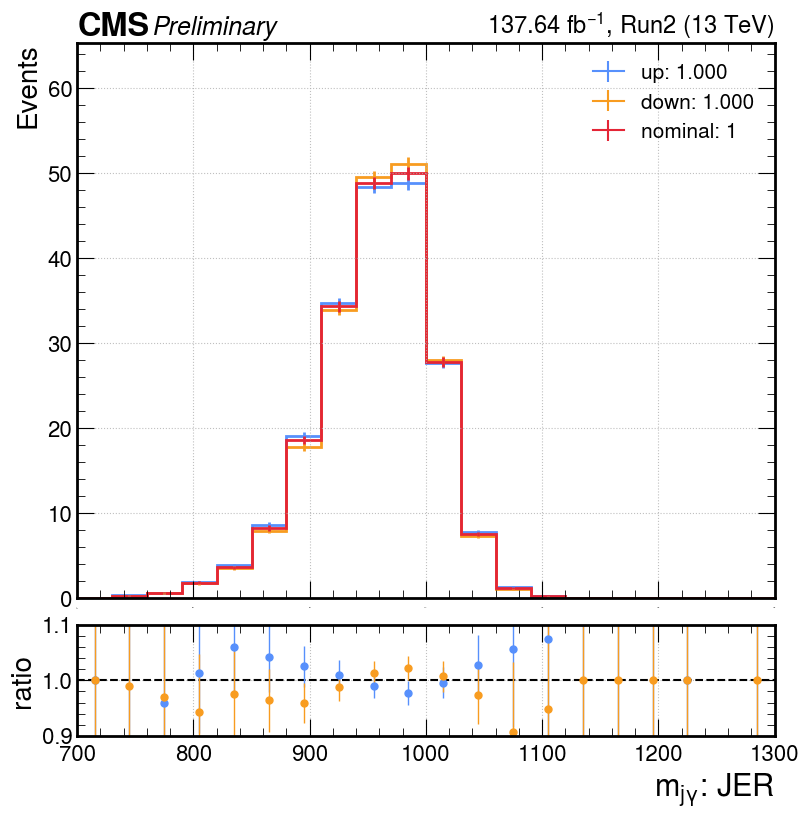

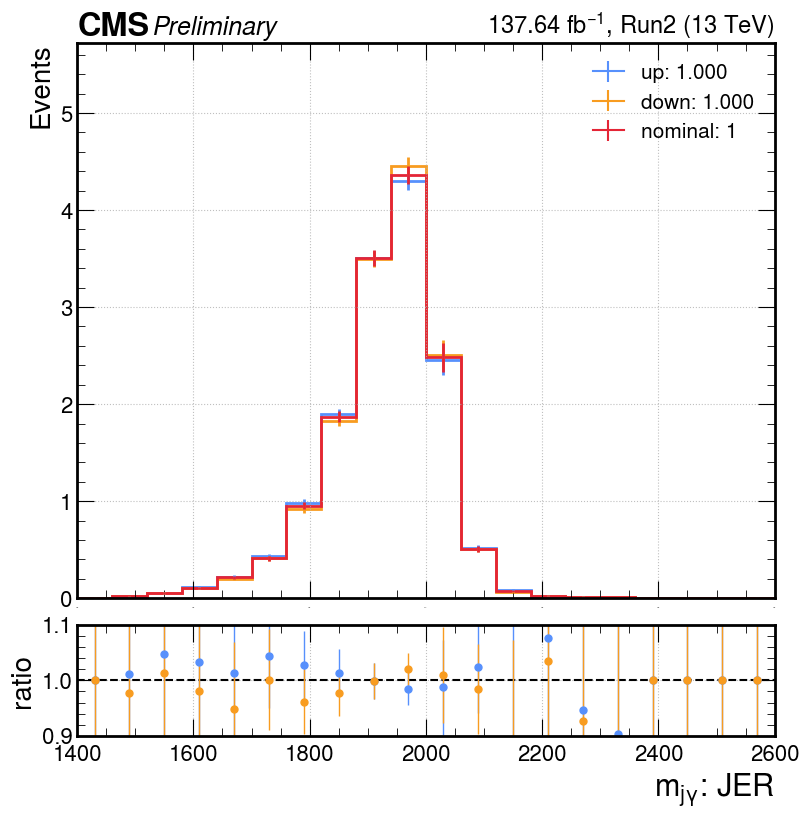

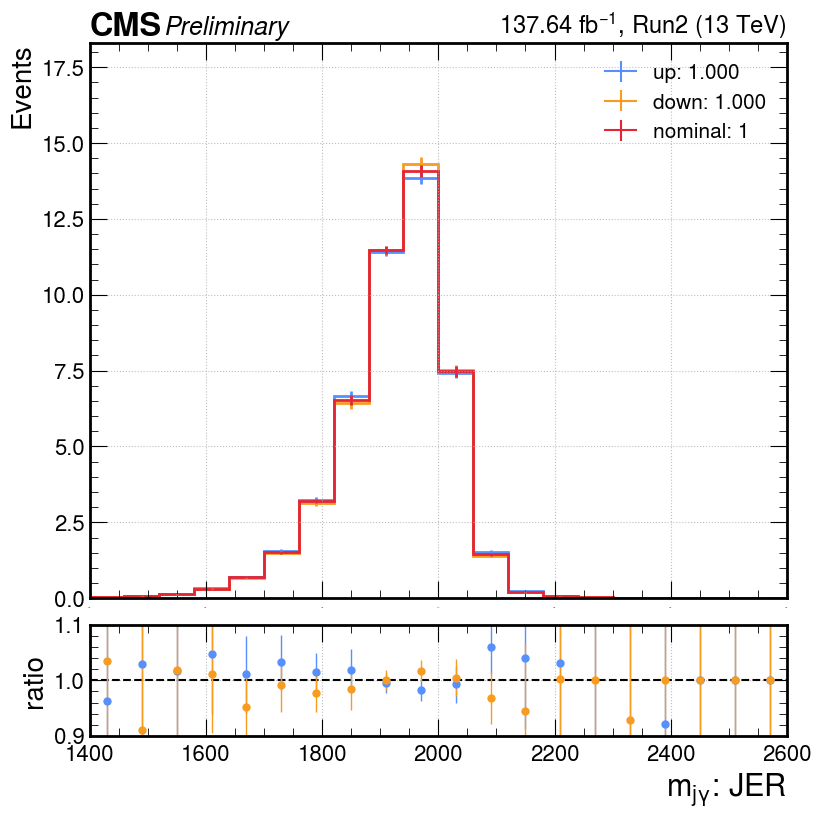

/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/1920557526.py:53: RuntimeWarning: invalid value encountered in divide
  ratio = h / individual['h']['nominal']
/tmp/ipykernel_4038097/1920557526.py:54: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan

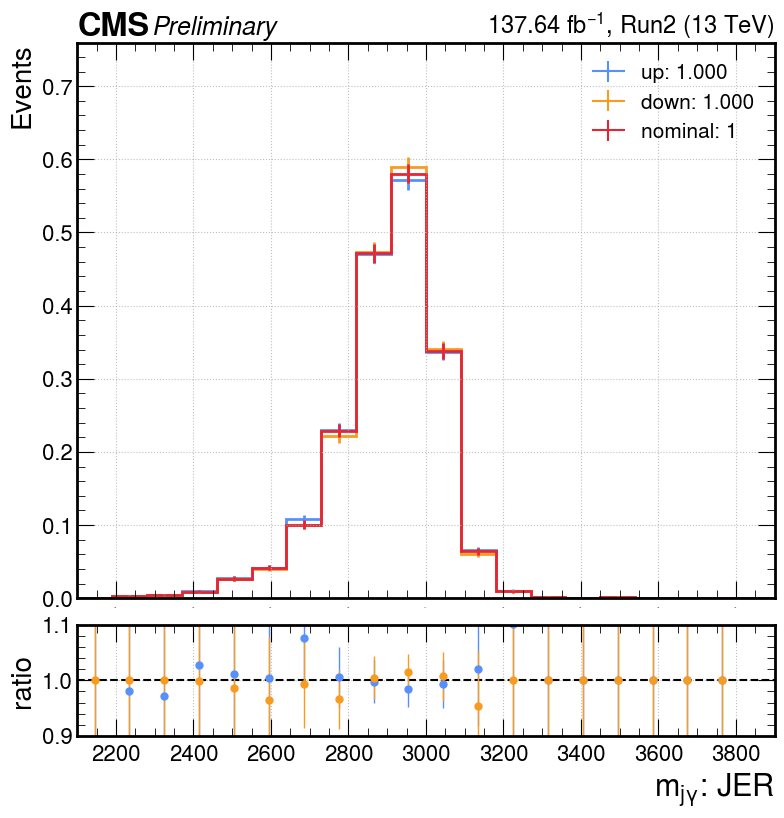

/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/1920557526.py:53: RuntimeWarning: invalid value encountered in divide
  ratio = h / individual['h']['nominal']
/tmp/ipykernel_4038097/1920557526.py:54: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan

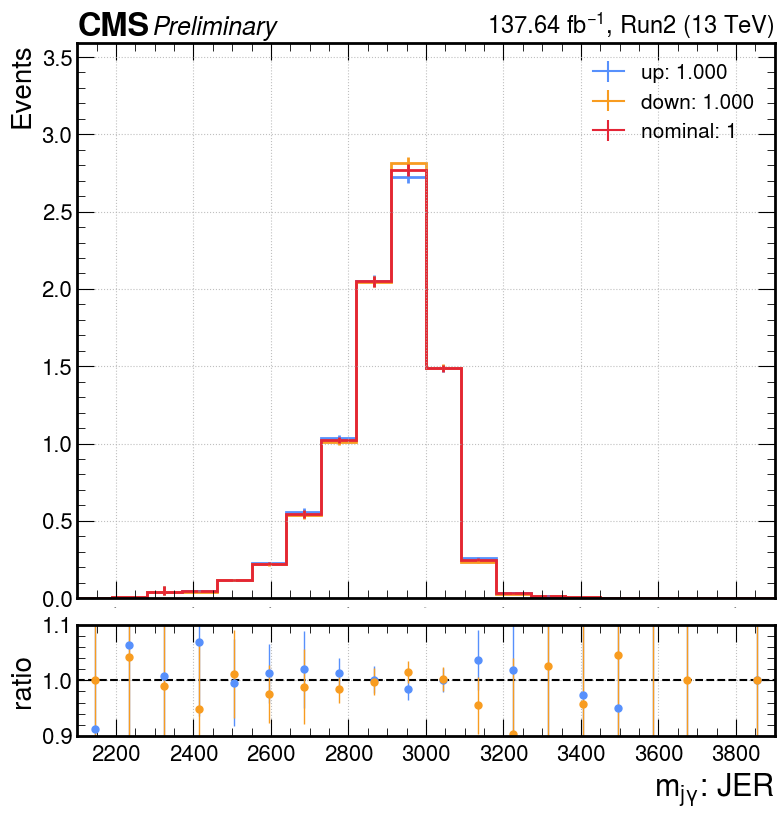

In [10]:
y='Run2'
for m in ('1000', '2000', '3000'):
    k=r'$Z^\mathrm{\prime}$('+ m + r')$\to H(bb)\gamma$'
    # SR1
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (tagger_Hbb[y][k]>0.7) & 
        (tagger_Hbb[y][k]<0.9) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] > 110) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] < 145)
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JER_down'][eval(cut)]
    }
    _weight = {
        i: weight[y][k][eval(cut)] for i in arrays.keys()
    }
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: JER', plot_name=f'JER_mass_m{m}_SR1', x_min=int(m)*0.7, x_max=int(m)*1.3, bins=20, weight=_weight, year=y, y_min=0.9, y_max=1.1)

    # SR2
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (tagger_Hbb[y][k]>0.9) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] > 110) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] < 145)
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JER_down'][eval(cut)]
    }
    _weight = {
        i: weight[y][k][eval(cut)] for i in arrays.keys()
    }
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: JER', plot_name=f'JER_mass_m{m}_SR2', x_min=int(m)*0.7, x_max=int(m)*1.3, bins=20, weight=_weight, year=y, y_min=0.9, y_max=1.1)

## Pile-up

/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/1920557526.py:53: RuntimeWarning: invalid value encountered in divide
  ratio = h / individual['h']['nominal']
/tmp/ipykernel_4038097/1920557526.py:54: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan

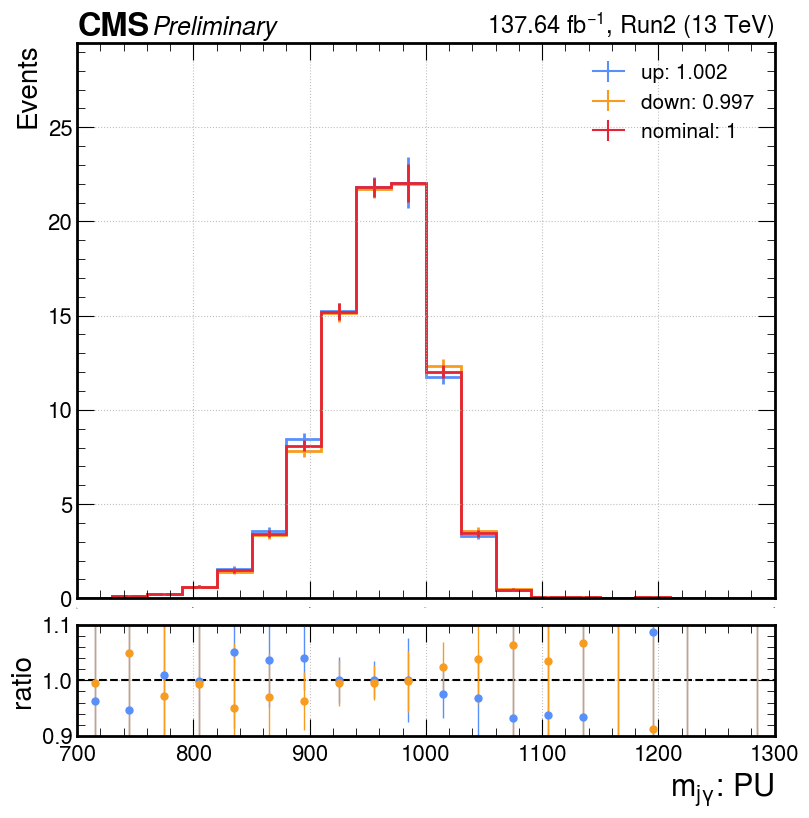

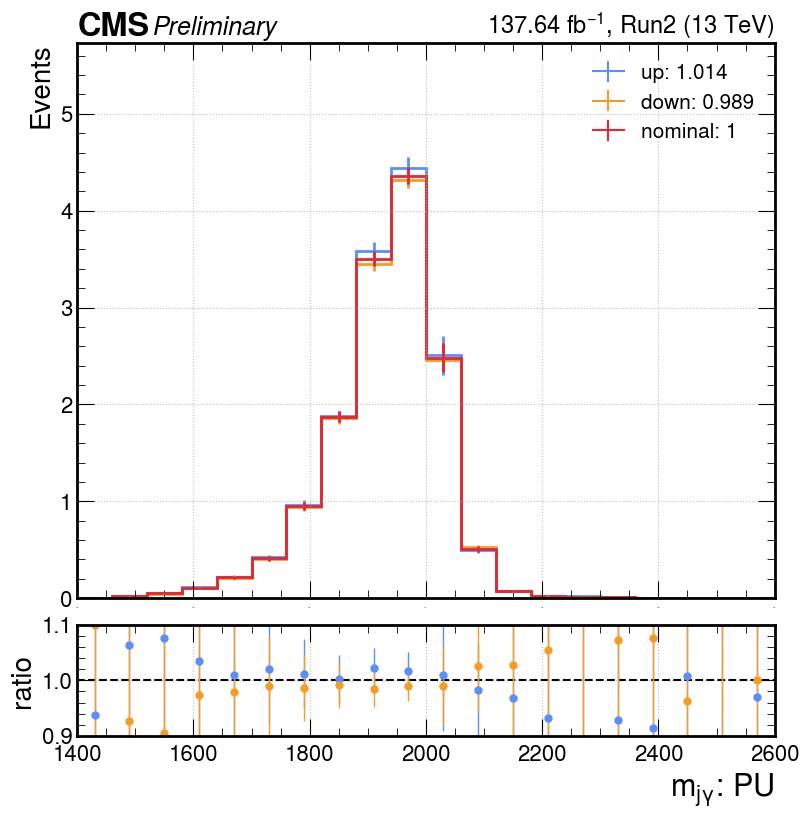

/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/1920557526.py:53: RuntimeWarning: invalid value encountered in divide
  ratio = h / individual['h']['nominal']
/tmp/ipykernel_4038097/1920557526.py:54: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan

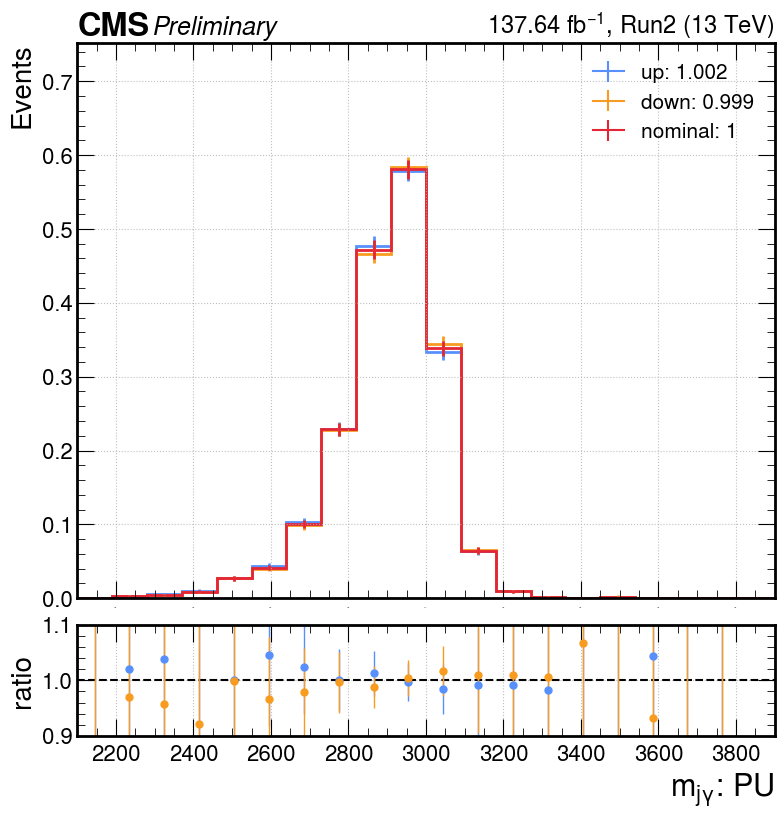

/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/1920557526.py:53: RuntimeWarning: invalid value encountered in divide
  ratio = h / individual['h']['nominal']
/tmp/ipykernel_4038097/1920557526.py:54: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan

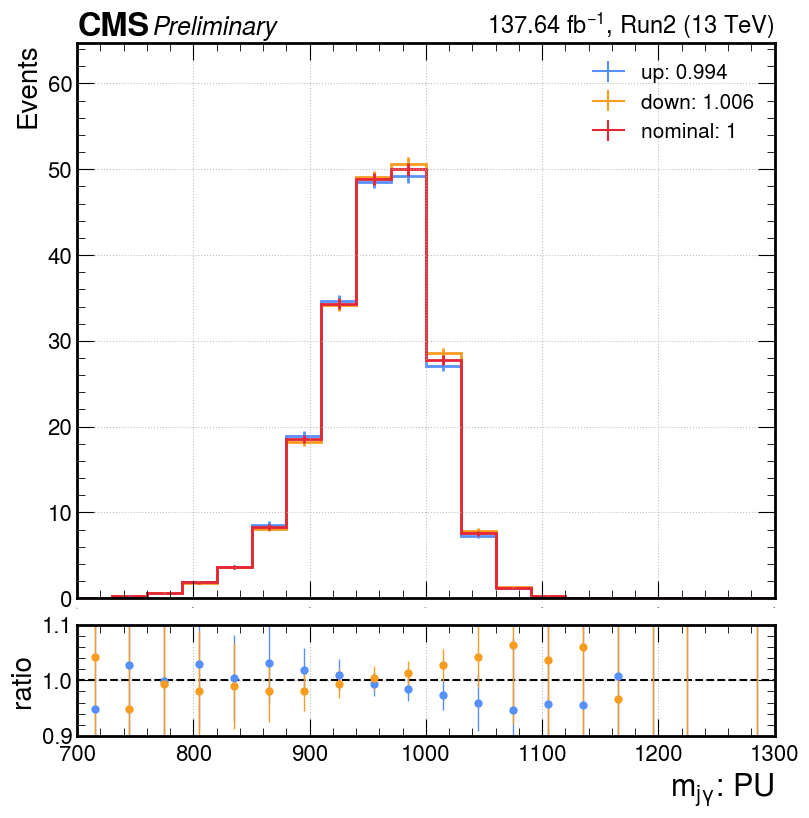

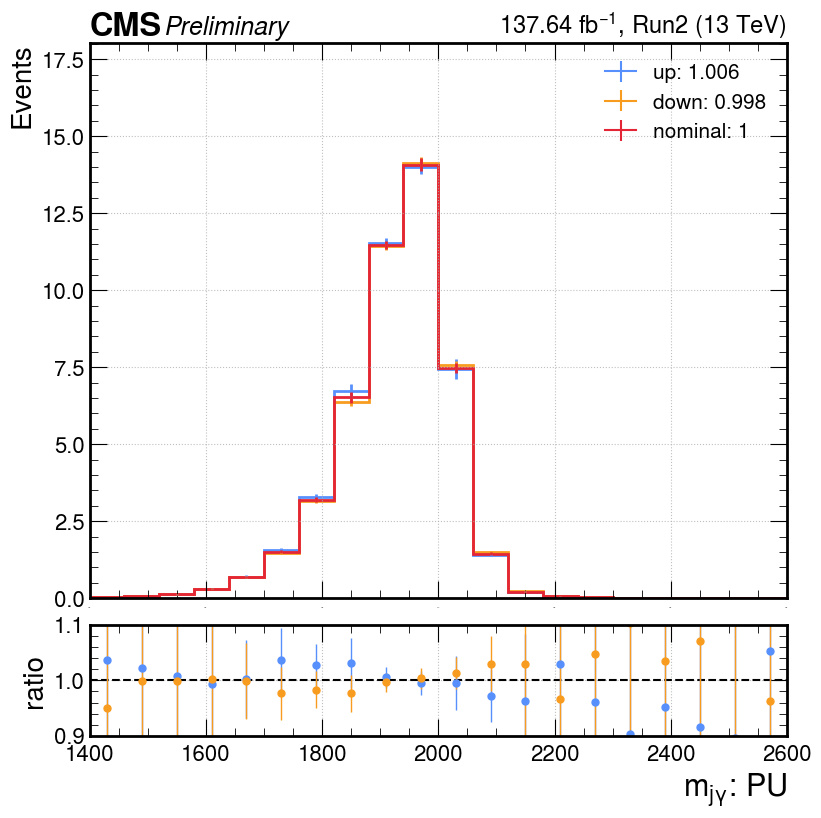

/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4038097/1920557526.py:53: RuntimeWarning: invalid value encountered in divide
  ratio = h / individual['h']['nominal']
/tmp/ipykernel_4038097/1920557526.py:54: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
/tmp/ipykernel_4038097/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4038097/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan

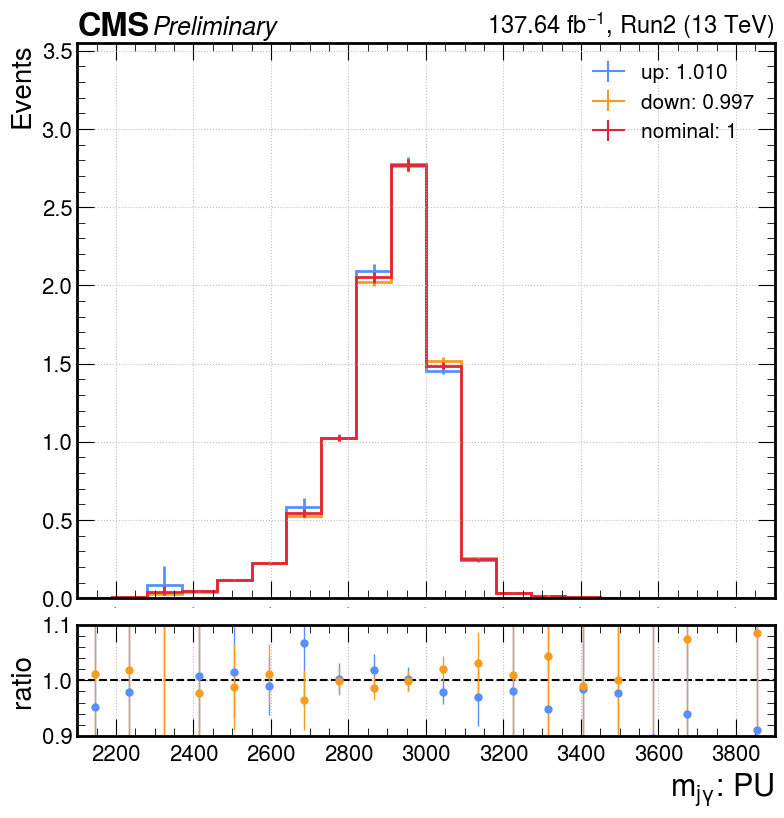

In [11]:
y='Run2'
for m in ('1000', '2000', '3000'):
    k=r'$Z^\mathrm{\prime}$('+ m + r')$\to H(bb)\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (tagger_Hbb[y][k]>0.7) & 
        (tagger_Hbb[y][k]<0.9) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] > 110) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] < 145)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['PUWeight_up']/events[y][k]['PUWeight_nominal'])[eval(cut)],
        'nominal': weight[y][k][eval(cut)],
        'down': (weight[y][k]*events[y][k]['PUWeight_down']/events[y][k]['PUWeight_nominal'])[eval(cut)],
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: PU', plot_name=f'PU_m{m}_SR1', x_min=0.7*int(m), x_max=1.3*int(m), bins=20, weight=_weight, year=y, y_min=0.9, y_max=1.1)

y='Run2'
for m in ('1000', '2000', '3000'):
    k=r'$Z^\mathrm{\prime}$('+ m + r')$\to H(bb)\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (tagger_Hbb[y][k]>0.9) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] > 110) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] < 145)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['PUWeight_up']/events[y][k]['PUWeight_nominal'])[eval(cut)],
        'nominal': weight[y][k][eval(cut)],
        'down': (weight[y][k]*events[y][k]['PUWeight_down']/events[y][k]['PUWeight_nominal'])[eval(cut)],
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: PU', plot_name=f'PU_m{m}_SR2', x_min=0.7*int(m), x_max=1.3*int(m), bins=20, weight=_weight, year=y, y_min=0.9, y_max=1.1)

## QCD Scale

/tmp/ipykernel_478976/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_478976/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_478976/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_478976/155468663.py:51: RuntimeWarning: invalid value encountered in divide
  ratio = h / individual['h']['nominal']
/tmp/ipykernel_478976/155468663.py:52: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
/tmp/ipykernel_478976/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_478976/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/

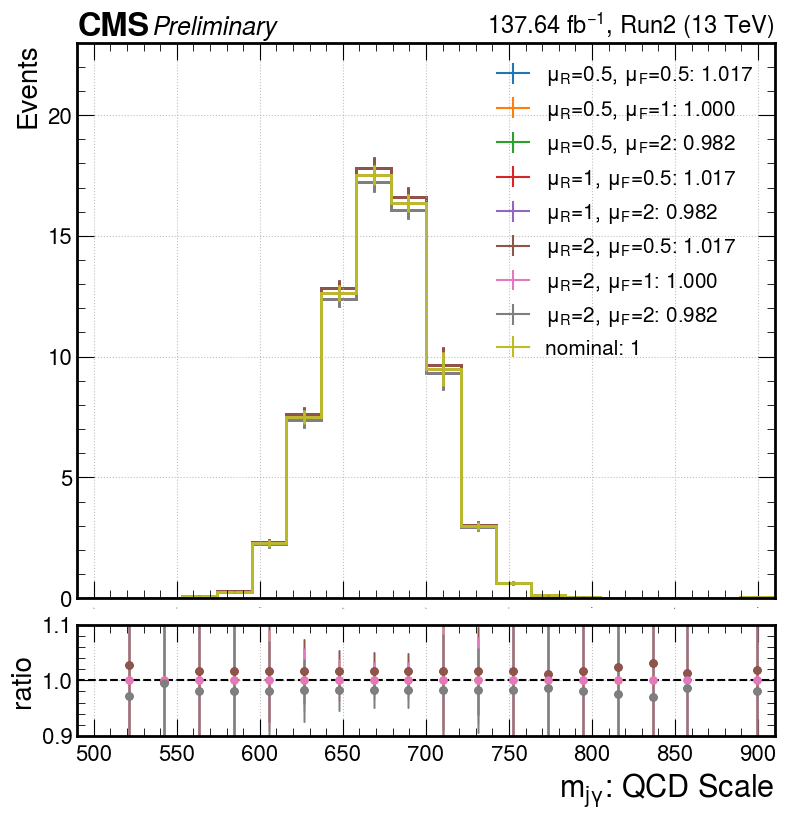

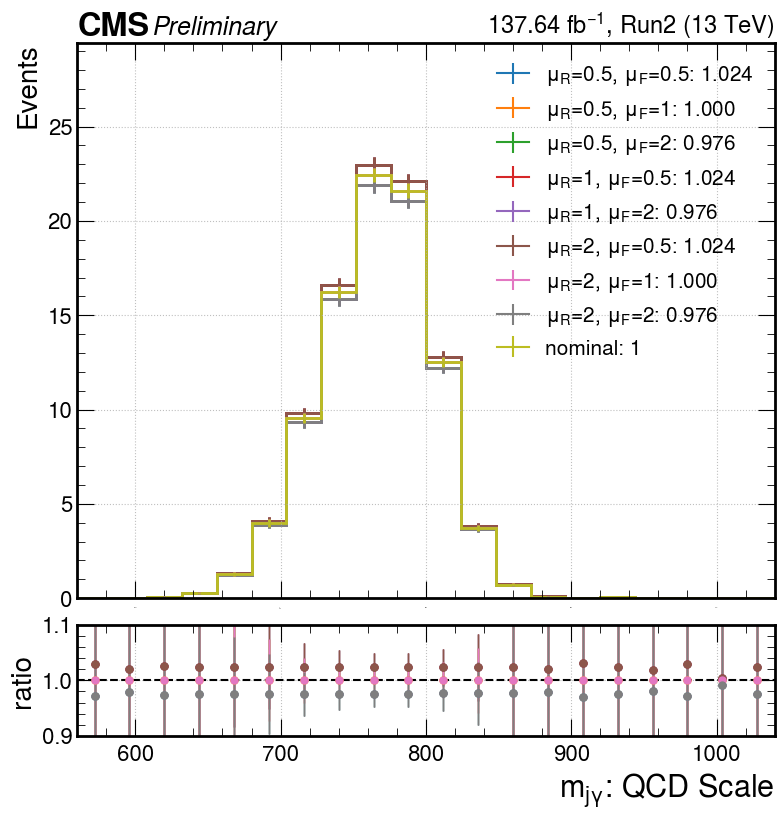

/tmp/ipykernel_478976/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_478976/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_478976/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_478976/155468663.py:51: RuntimeWarning: invalid value encountered in divide
  ratio = h / individual['h']['nominal']
/tmp/ipykernel_478976/155468663.py:52: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
/tmp/ipykernel_478976/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_478976/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/

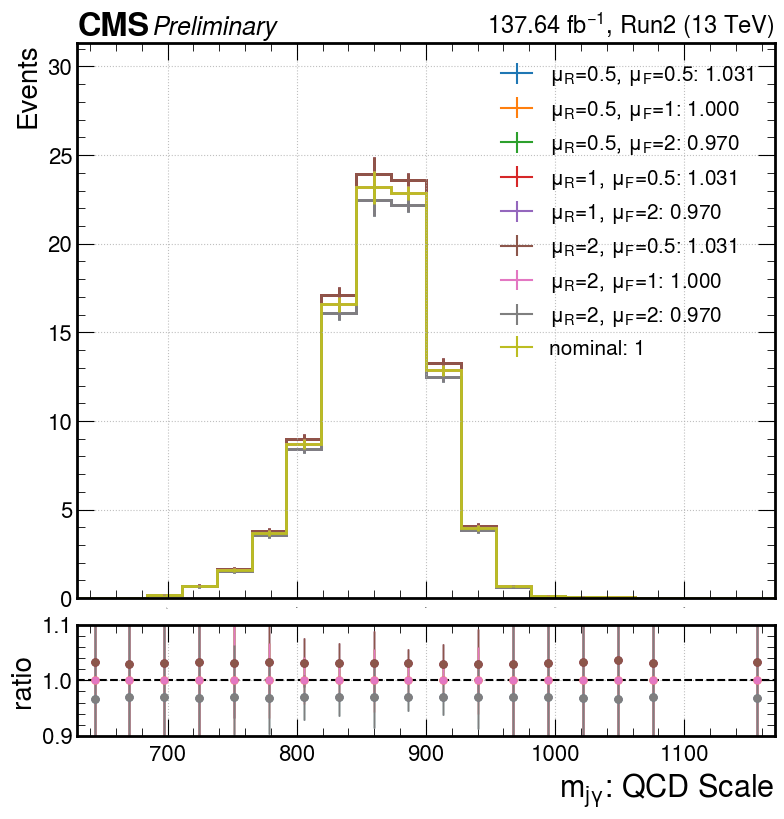

/tmp/ipykernel_478976/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_478976/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_478976/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_478976/155468663.py:51: RuntimeWarning: invalid value encountered in divide
  ratio = h / individual['h']['nominal']
/tmp/ipykernel_478976/155468663.py:52: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
/tmp/ipykernel_478976/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_478976/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/

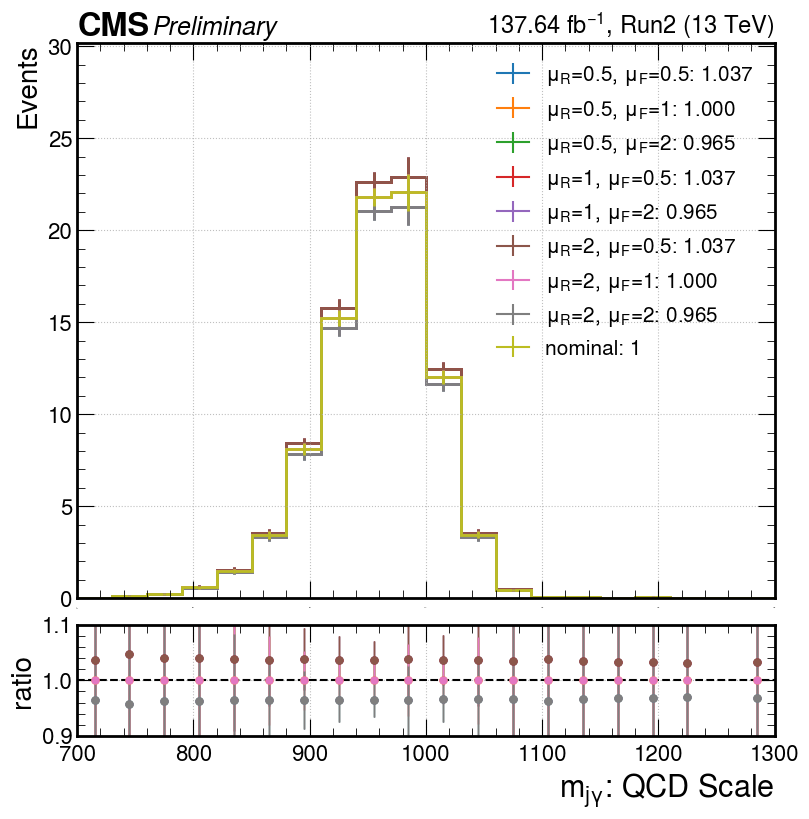

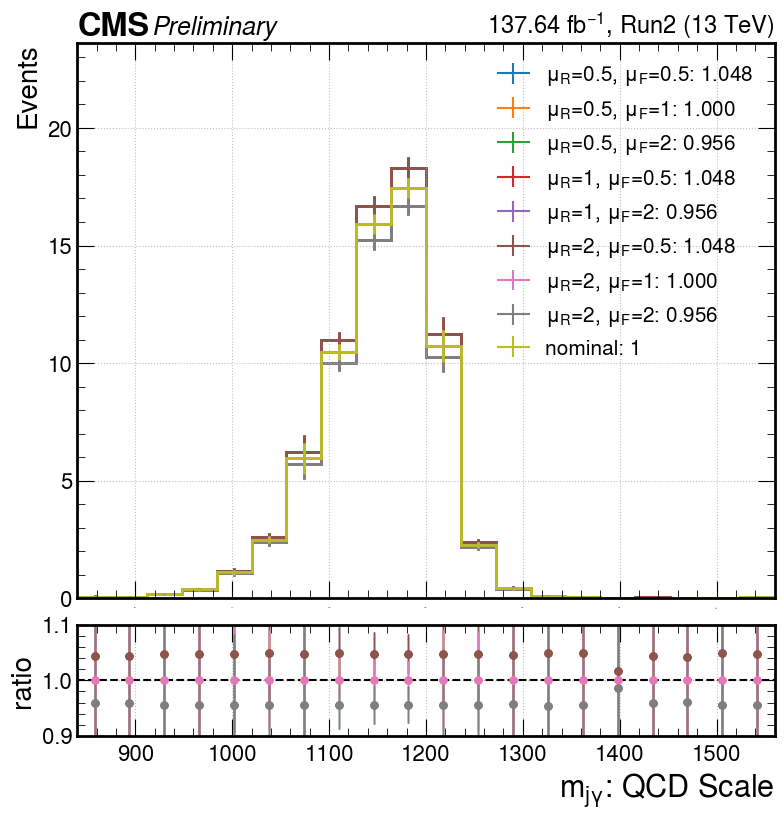

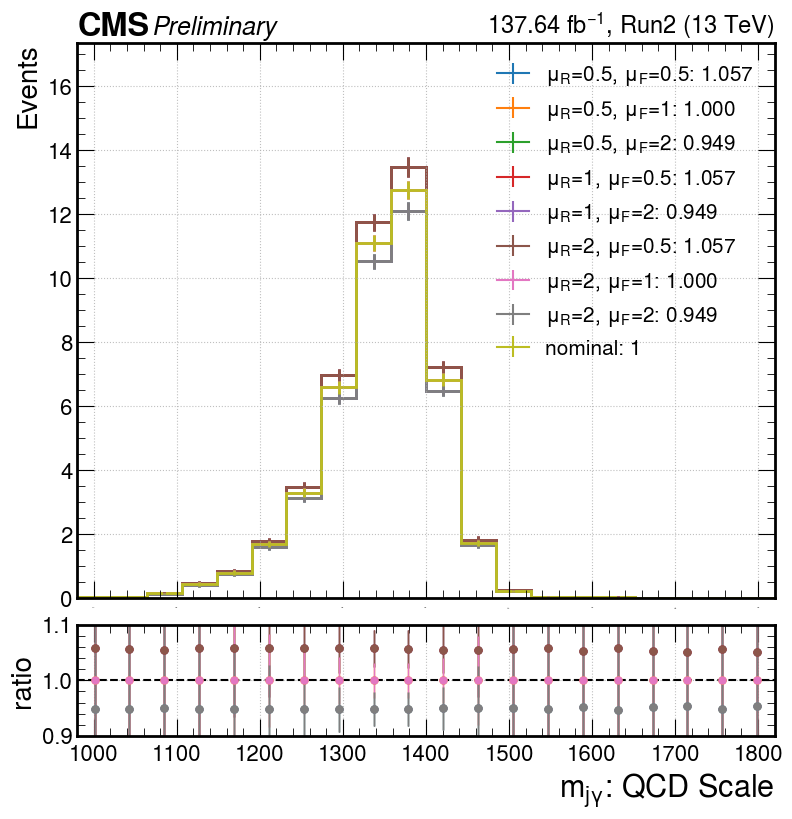

/tmp/ipykernel_478976/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_478976/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_478976/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_478976/155468663.py:51: RuntimeWarning: invalid value encountered in divide
  ratio = h / individual['h']['nominal']
/tmp/ipykernel_478976/155468663.py:52: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
/tmp/ipykernel_478976/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_478976/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/

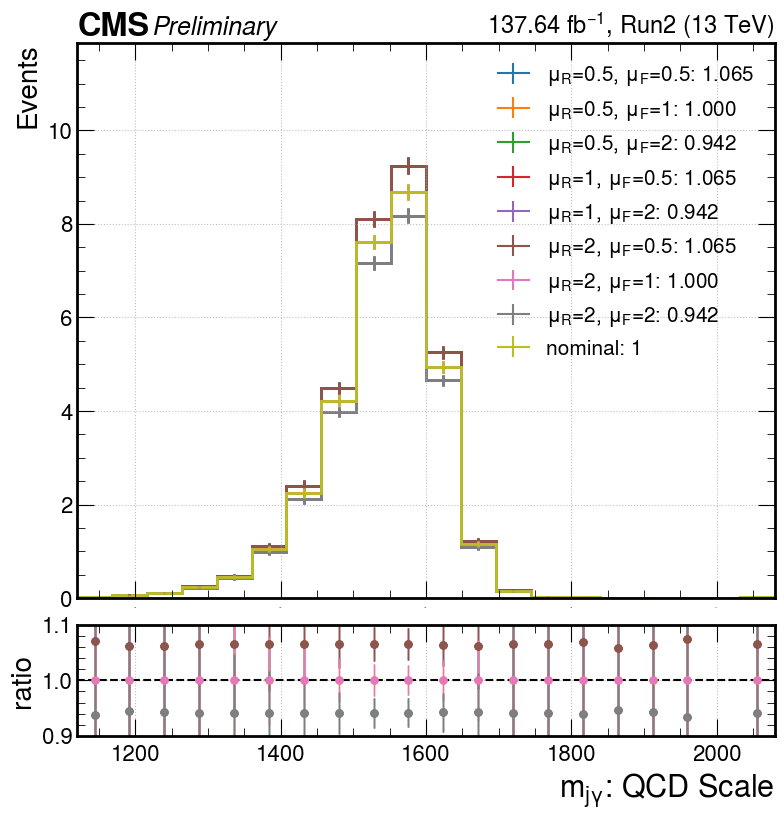

/tmp/ipykernel_478976/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_478976/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_478976/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_478976/155468663.py:51: RuntimeWarning: invalid value encountered in divide
  ratio = h / individual['h']['nominal']
/tmp/ipykernel_478976/155468663.py:52: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
/tmp/ipykernel_478976/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_478976/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/

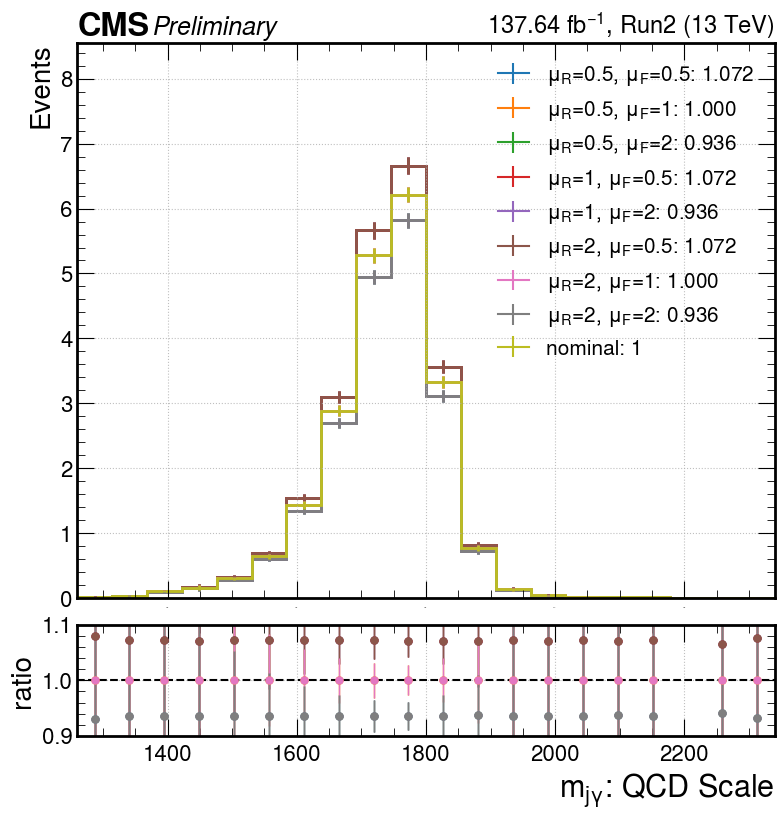

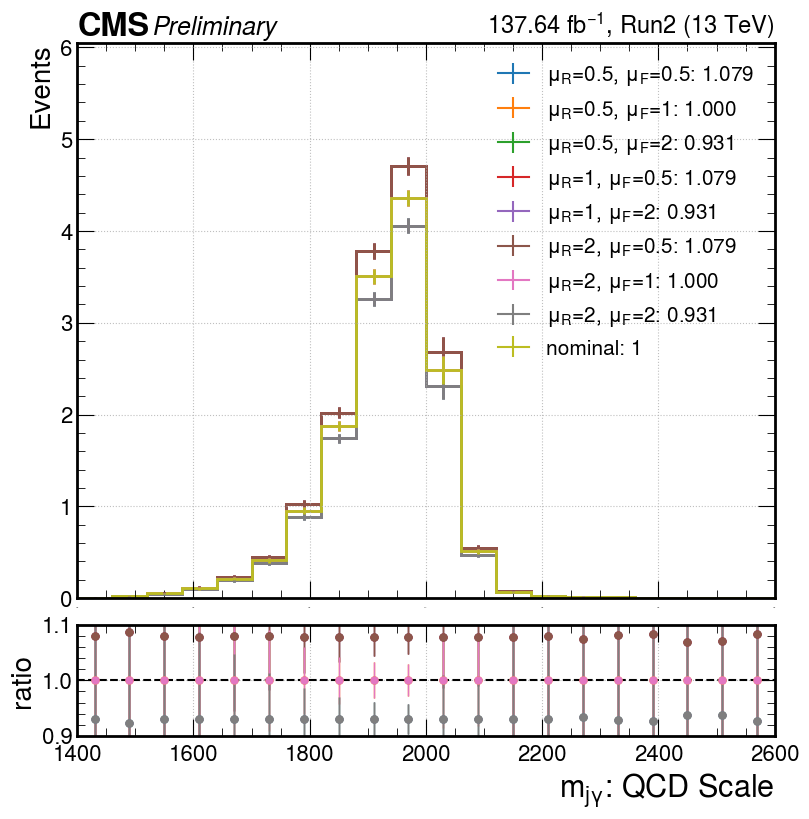

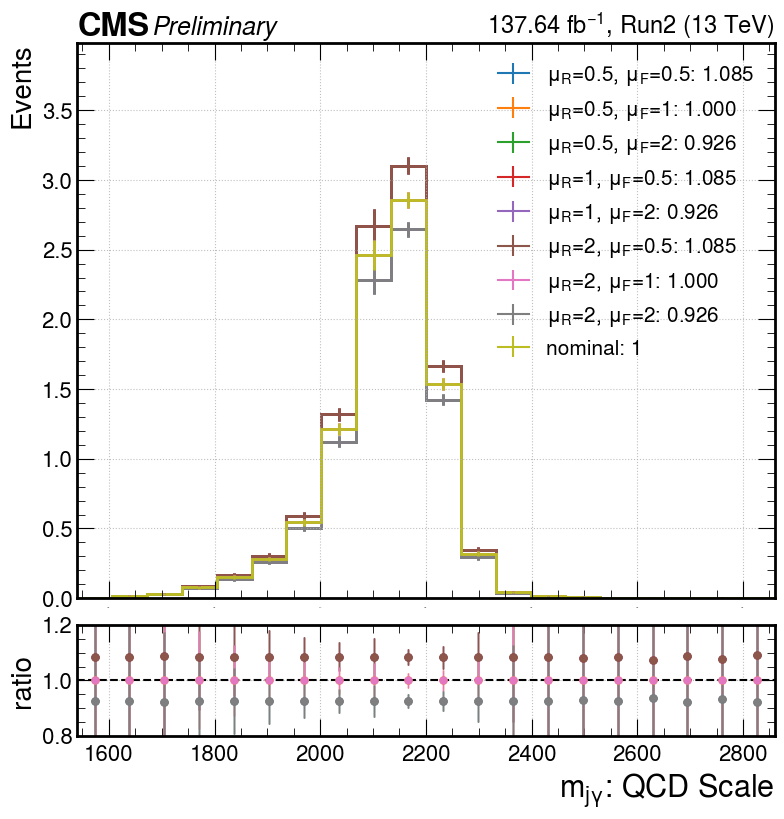

In [ ]:
y='Run2'
for m in [700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 3000, 3500]:
    if m > 2000:
        y_min, y_max = 0.8, 1.2
    else:
        y_min, y_max = 0.9, 1.1
    k=r'$Z^\mathrm{\prime}$('+str(m)+r')$\to H(bb)\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (tagger_Hbb[y][k]>0.7) & 
        (tagger_Hbb[y][k]<0.9) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] > 110) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] < 145)
    )"""
    _weight = {
        r'$\mu_R$=0.5, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
        r'$\mu_R$=0.5, $\mu_F$=1': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 1])[eval(cut)],
        r'$\mu_R$=0.5, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 2])[eval(cut)],
        r'$\mu_R$=1, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 3])[eval(cut)],
        'nominal': weight[y][k][eval(cut)],
        r'$\mu_R$=1, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 4])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 5])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=1': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 6])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 7])[eval(cut)],
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: QCD Scale', plot_name=f'QCDScale_m{m}_SR1', x_min=0.7*int(m), x_max=1.3*int(m), bins=20, weight=_weight, year=y, y_min=y_min, y_max=y_max)

y='Run2'
for m in [700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 3000, 3500]:
    if m > 2000:
        y_min, y_max = 0.8, 1.2
    else:
        y_min, y_max = 0.9, 1.1
    k=r'$Z^\mathrm{\prime}$('+str(m)+ r')$\to H(bb)\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (tagger_Hbb[y][k]>0.9) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] > 110) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] < 145)
    )"""
    _weight = {
        r'$\mu_R$=0.5, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
        r'$\mu_R$=0.5, $\mu_F$=1': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 1])[eval(cut)],
        r'$\mu_R$=0.5, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 2])[eval(cut)],
        r'$\mu_R$=1, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 3])[eval(cut)],
        'nominal': weight[y][k][eval(cut)],
        r'$\mu_R$=1, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 4])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 5])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=1': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 6])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 7])[eval(cut)],
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: QCD Scale', plot_name=f'QCDScale_m{m}_SR2', x_min=0.7*int(m), x_max=1.3*int(m), bins=20, weight=_weight, year=y, y_min=y_min, y_max=y_max)

## PDF

In [9]:
def pdf_uncertainty_plot(arrays, weight, plot_name: str, x_name: str, year='2018', bins=40, x_min=0, x_max=2000, overflow=True, underflow=False, y_min=0.9, y_max=1.1, x_axis=None):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))
    bin_width = (x_max-x_min)/bins
        
    ## canvas initializing
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.08)
    ax, ax1 = f.add_subplot(gs[0]), f.add_subplot(gs[1])
    ax.grid(); ax1.grid()
    hep.cms.label(data=False, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')

    ## analyze
    histogram, variance = {}, {}
    for i in range(len(weight[0])):
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        hist.fill(arrays, weight=weight[:, i])
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        histogram[i] = h
        variance[i] = var
    h_variation = np.sqrt(np.sum((np.array(list(histogram.values())) - histogram[0])**2, axis=0))
    histogram['nominal'] = histogram[0]
    histogram['up'] = histogram['nominal'] + h_variation
    histogram['down'] = histogram['nominal'] - h_variation
    err = error_bar(histogram[0], variance[0], mode='mc')

    
    ## plot
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    #COLOR = {'nominal': 'blue', 'up': 'red', 'down': 'green'}
    for k in ('up', 'down', 'nominal'):
        if k == 'nominal':
            continue
        histogram[k] = ak.where(histogram[k]>0, histogram[k], 0)
        SF = np.sum(histogram[k]) / np.sum(histogram['nominal'])
        hep.histplot(histogram[k], bins=hist.axes[0].edges, yerr=err, label=f'{k}: %.3f'%SF, histtype='step', density=False, stack=False, linewidth=2, ax=ax)
        ratio = histogram[k] / histogram['nominal']
        ratio_err = ratio * np.sqrt((err/histogram[k])**2 + (err/histogram['nominal'])**2)
        hep.histplot(ratio, bins=hist.axes[0].edges, yerr=ratio_err, histtype='errorbar', density=False, stack=False, ax=ax1)
    hep.histplot(histogram['nominal'], bins=hist.axes[0].edges, yerr=err, label='nominal: 1', histtype='step', density=False, stack=False, linewidth=2, ax=ax)
    

    ## axises
    ax.set_xlim(x_min, x_max)
    # ax.set_xticklabels([])
    ax.set_ylim(0, ax.get_ylim()[1]*1.2)
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    # x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    # y_major_locator=MultipleLocator(1)
    # ax.xaxis.set_major_locator(x_major_locator)
    # ax.yaxis.set_major_locator(y_major_locator)
    ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax1.set_ylim(y_min, y_max)
    ax1.set_ylabel('ratio', ha='center', fontsize=20)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)

    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=15)
    # plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')

    ## finalizing
    if not os.path.exists(f'./plots/{year}'):
        os.makedirs(f'./plots/{year}')
    plt.savefig(f"./plots/{year}/{plot_name}.pdf", bbox_inches='tight')

/tmp/ipykernel_478976/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_478976/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_478976/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/home/fudawei/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:249: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
/tmp/ipykernel_478976/163957893.py:39: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((err/histogram[k])**2 + (err/histogram['nominal'])**2)
/home/fudawei/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:249: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
/tmp/ipykernel_478976/163957893.

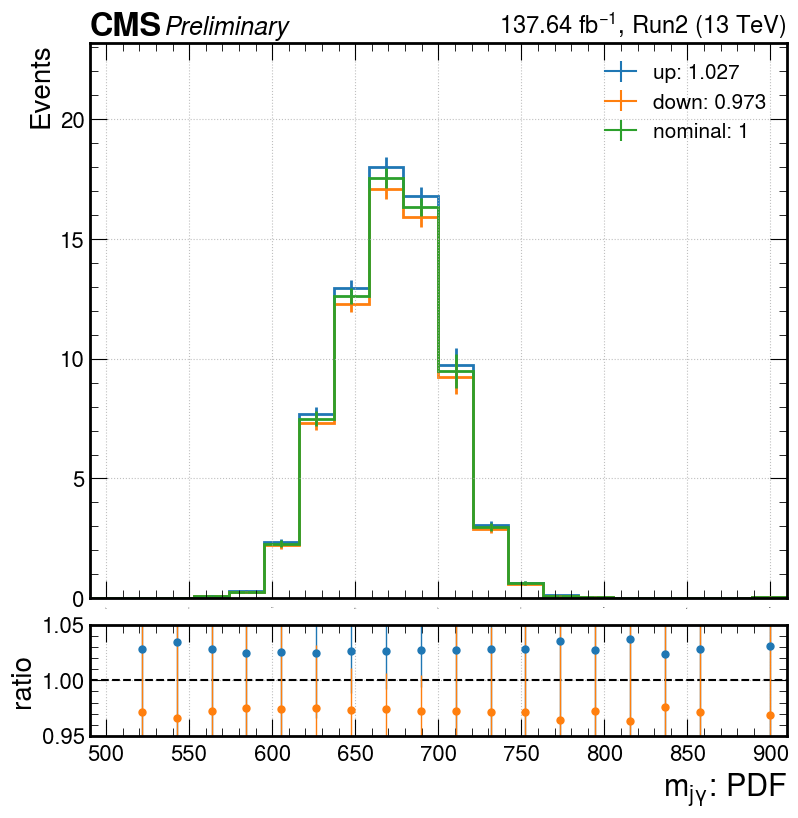

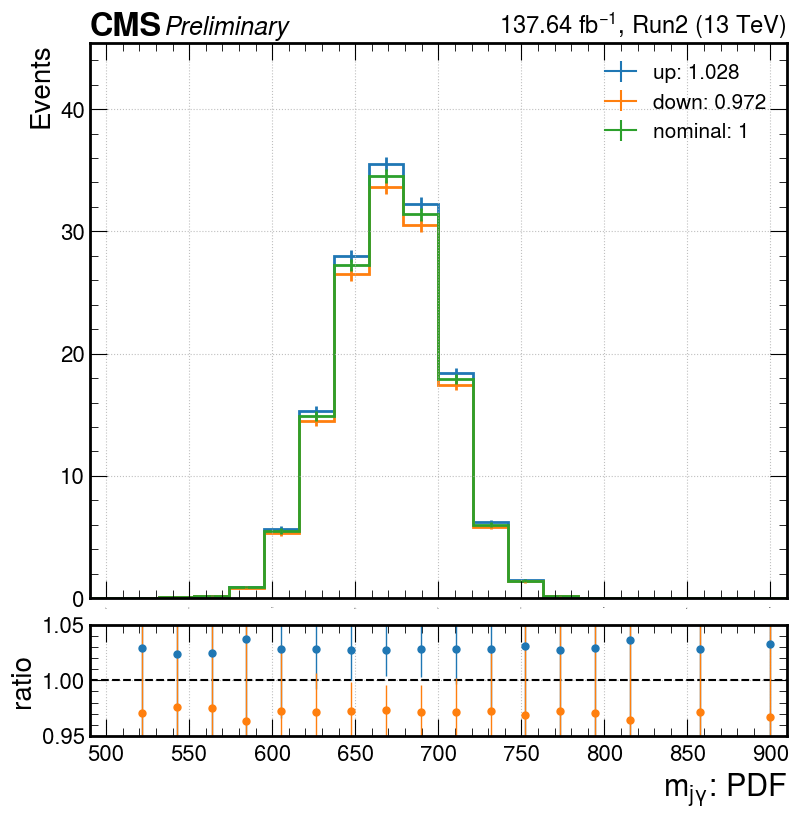

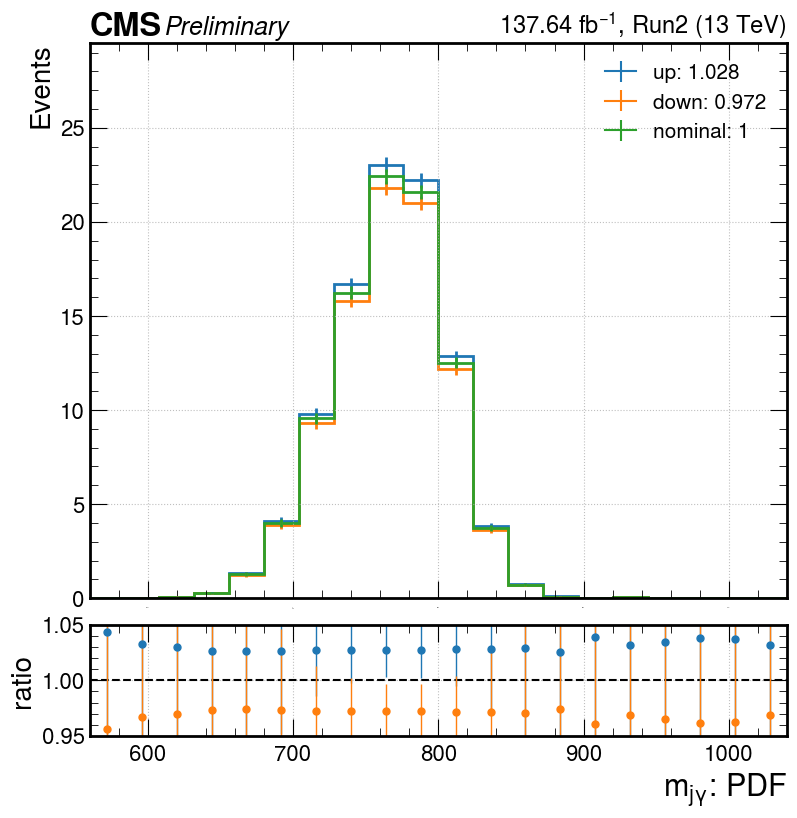

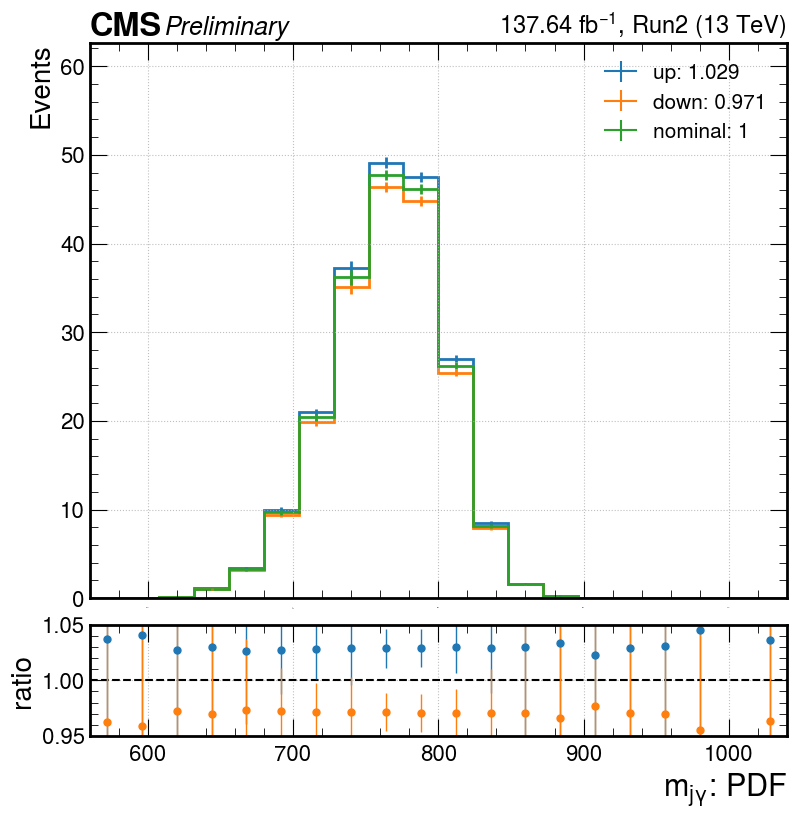

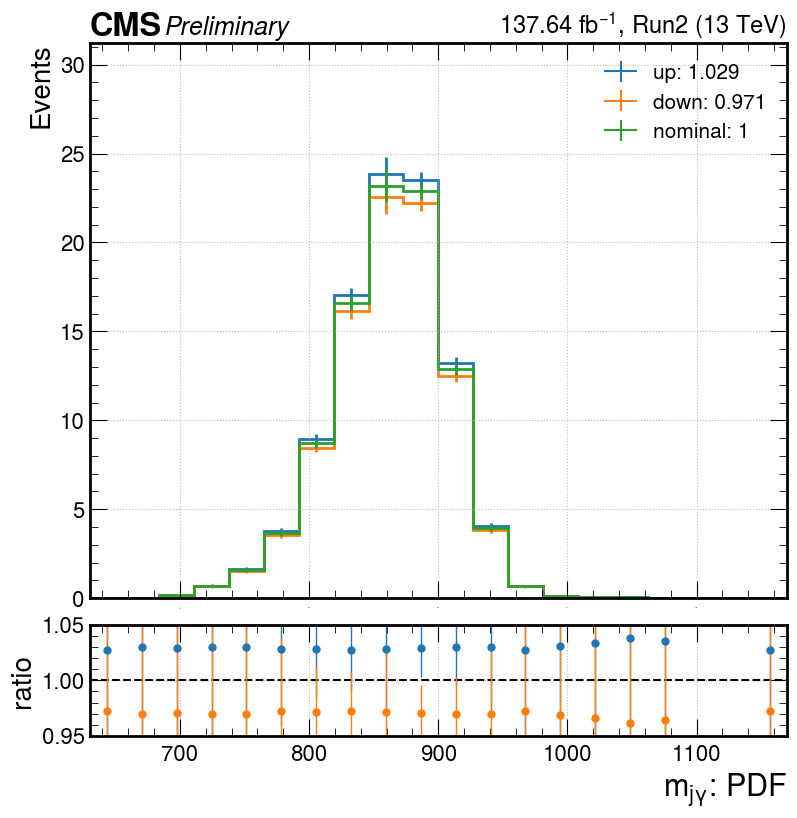

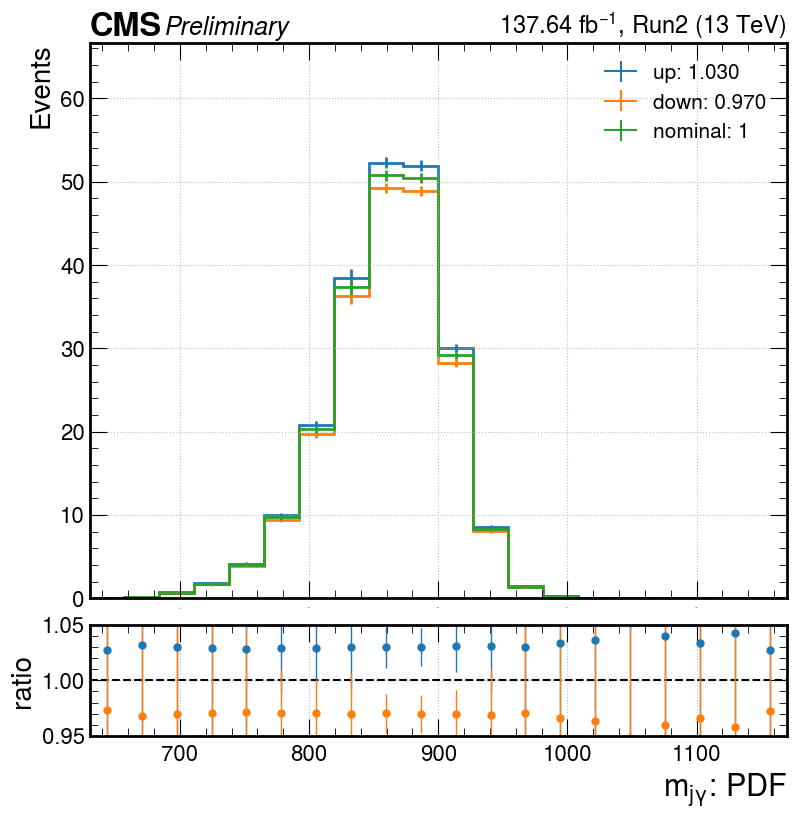

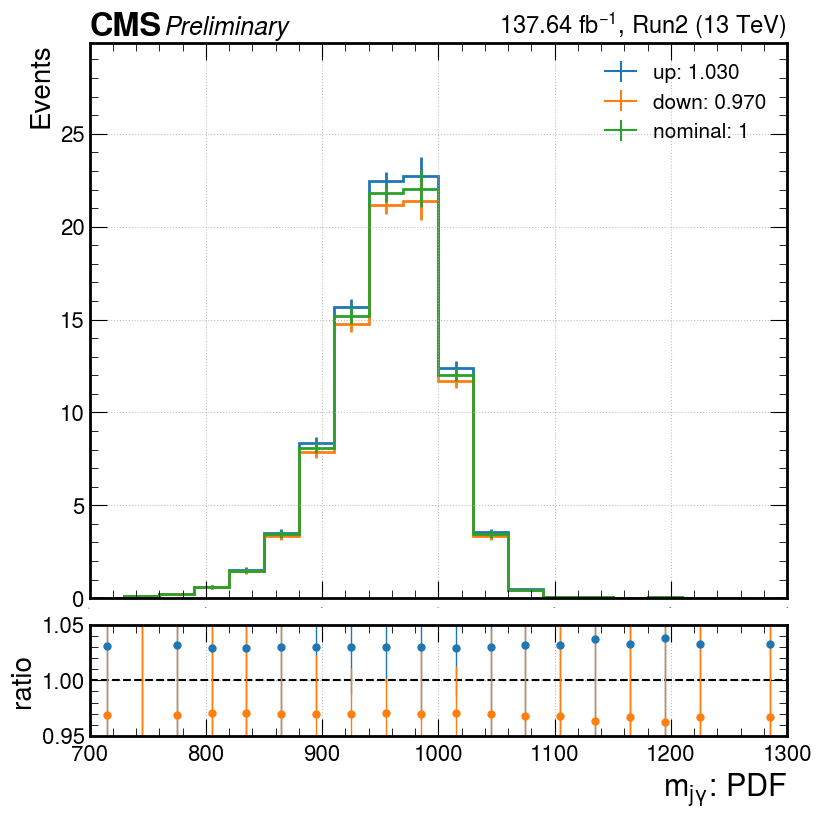

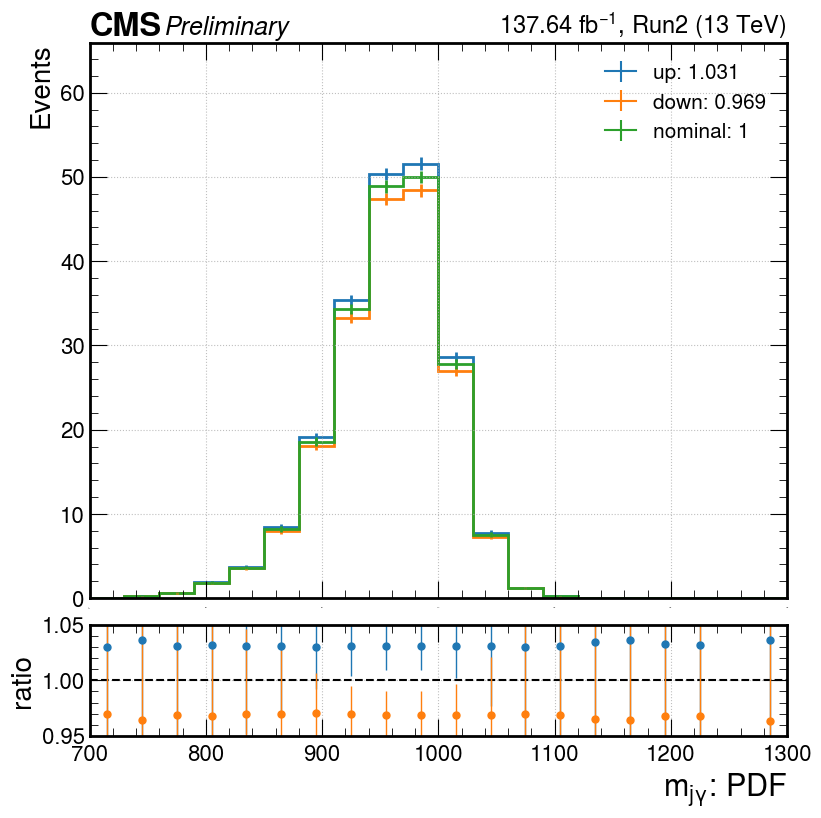

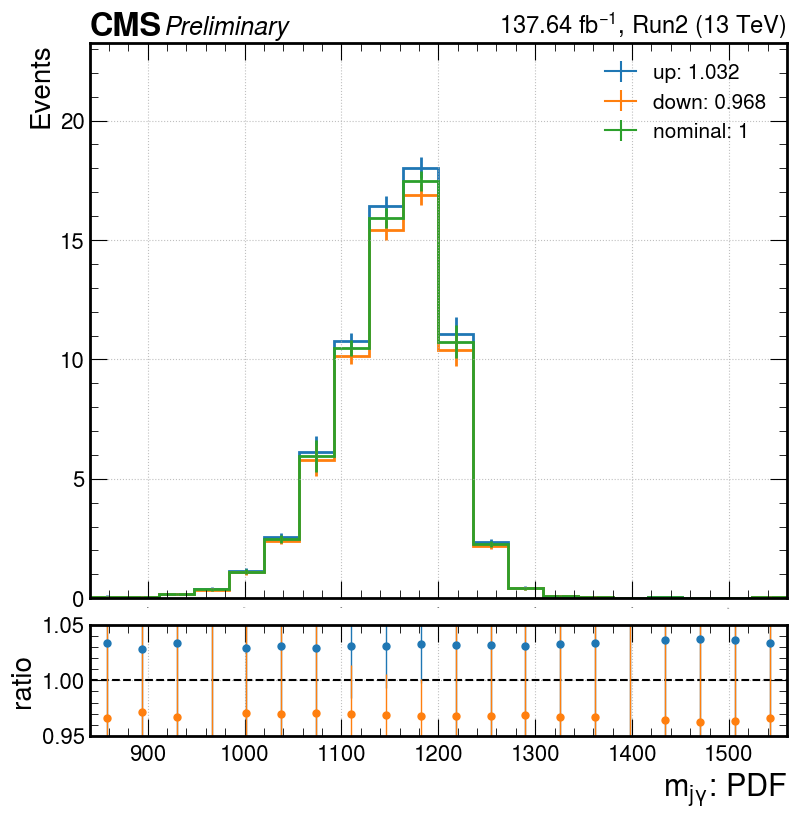

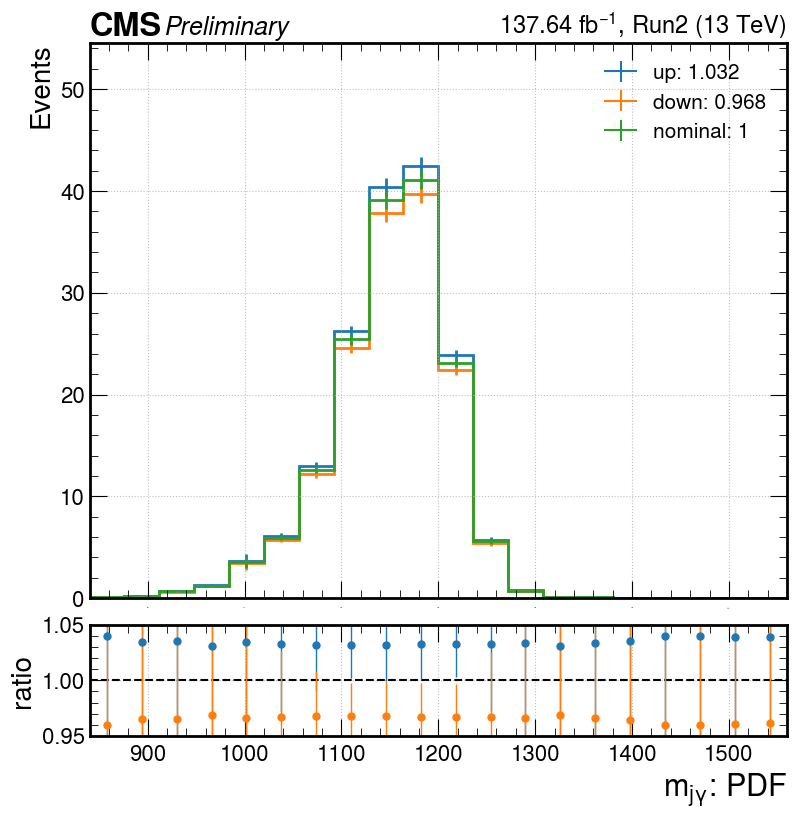

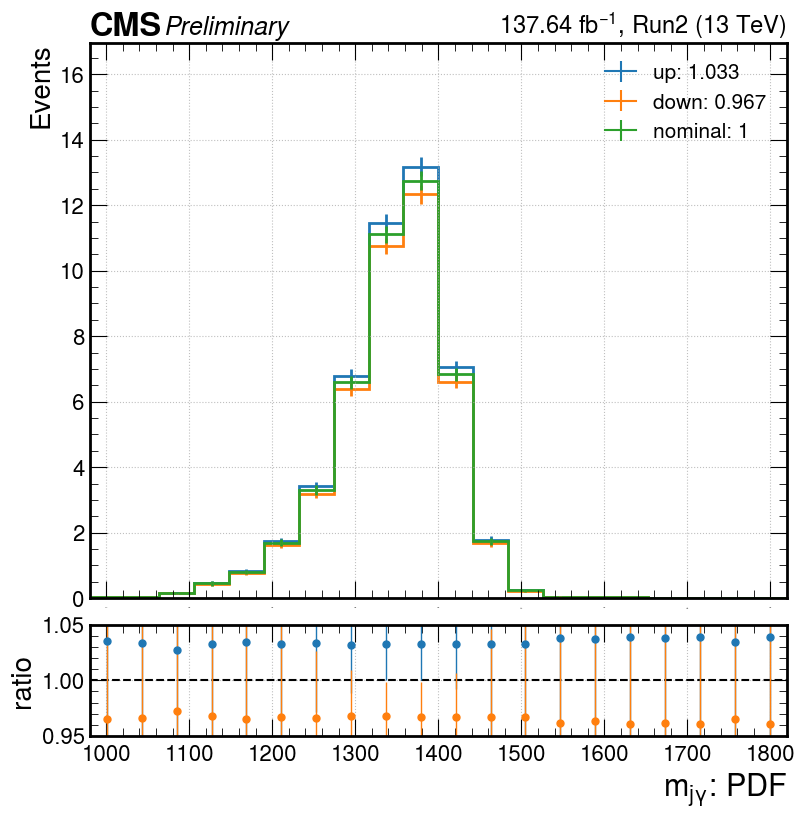

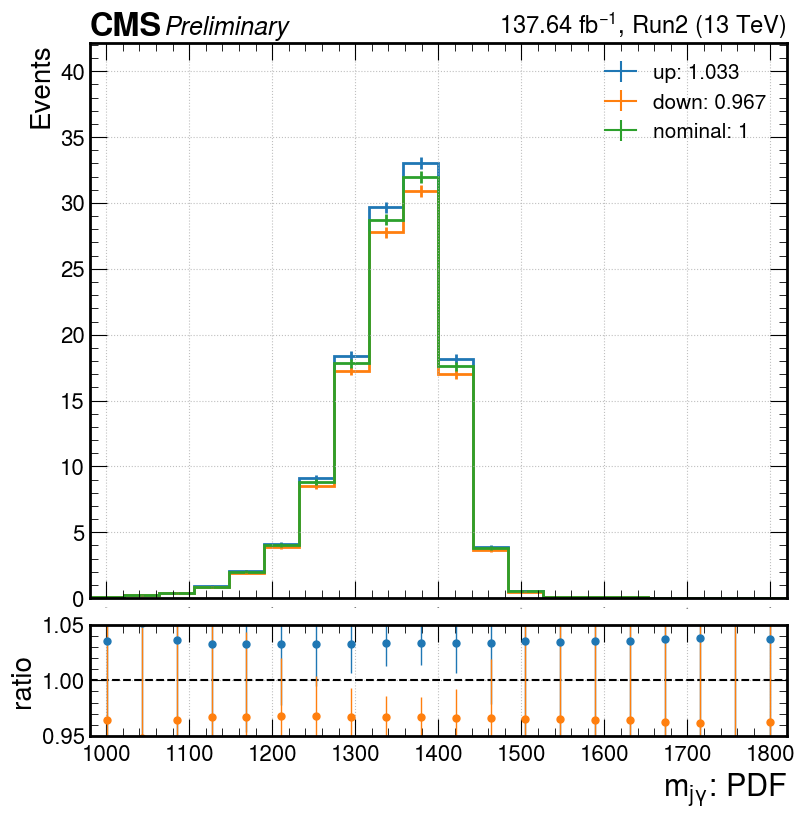

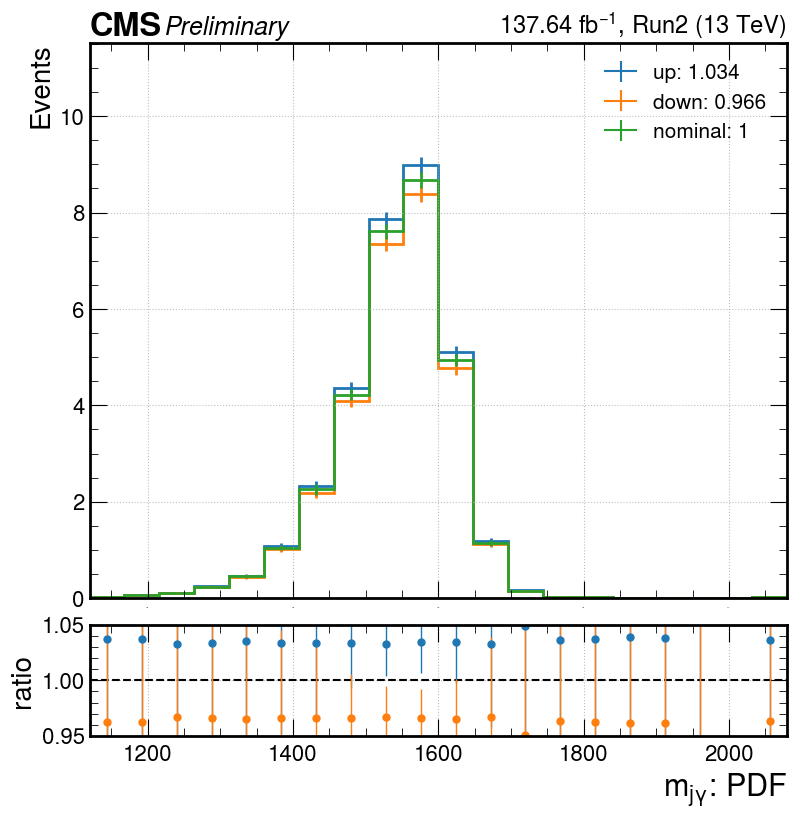

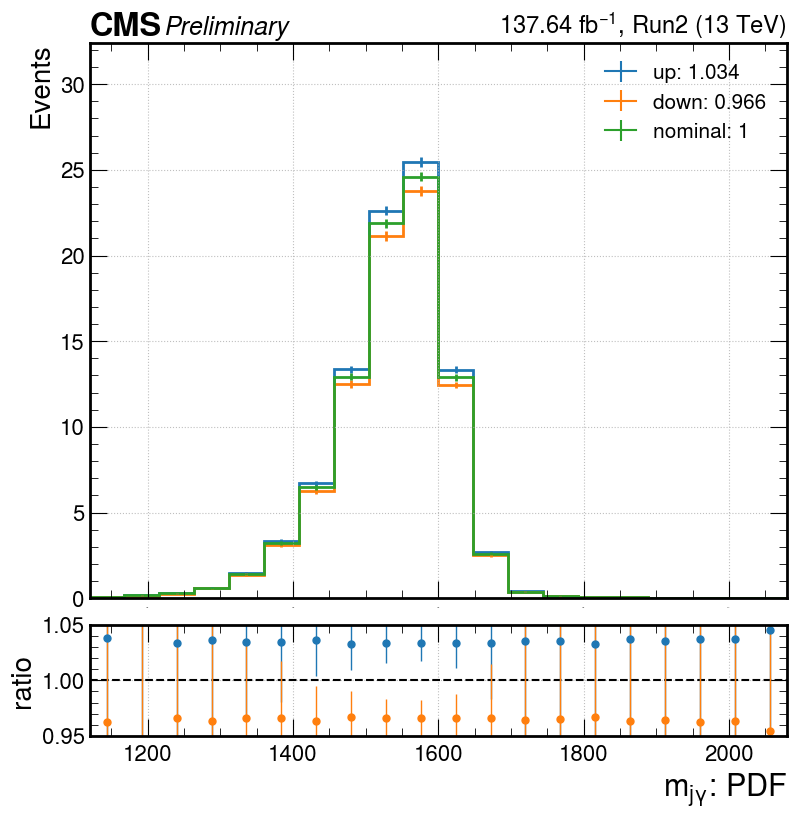

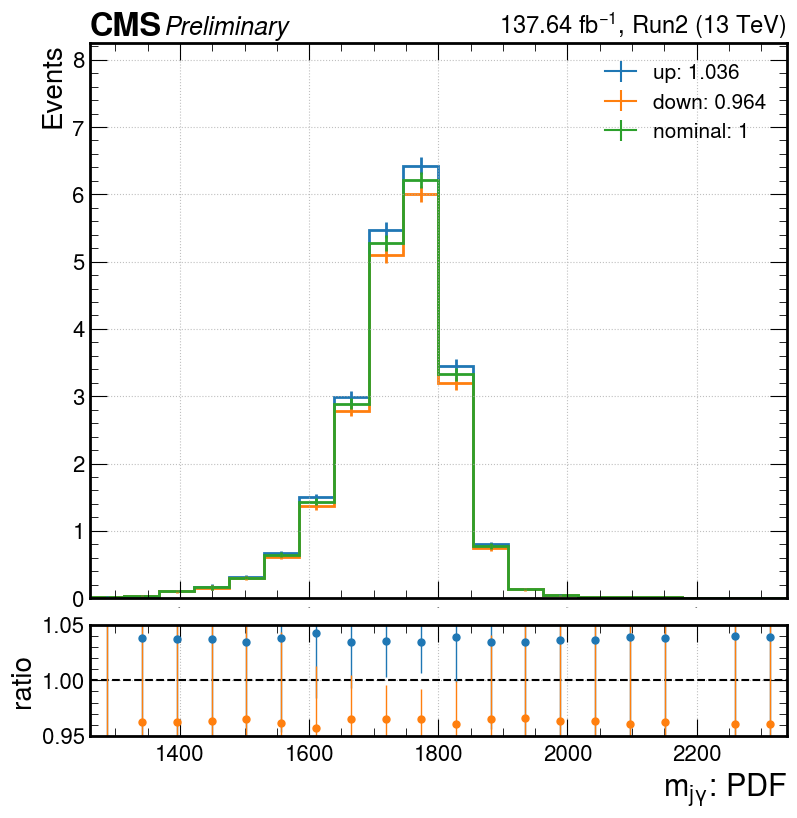

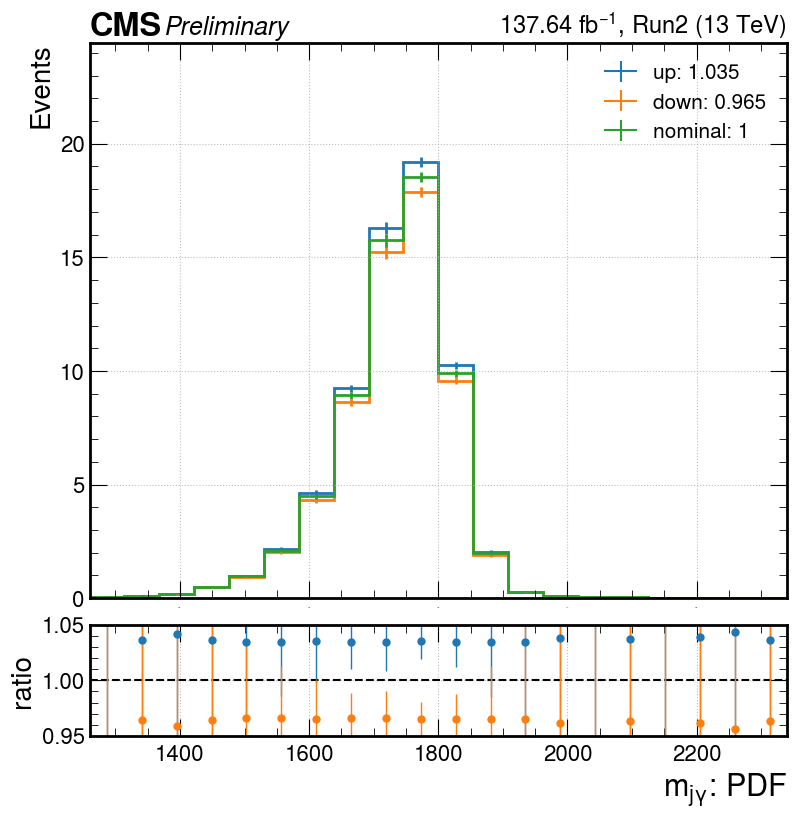

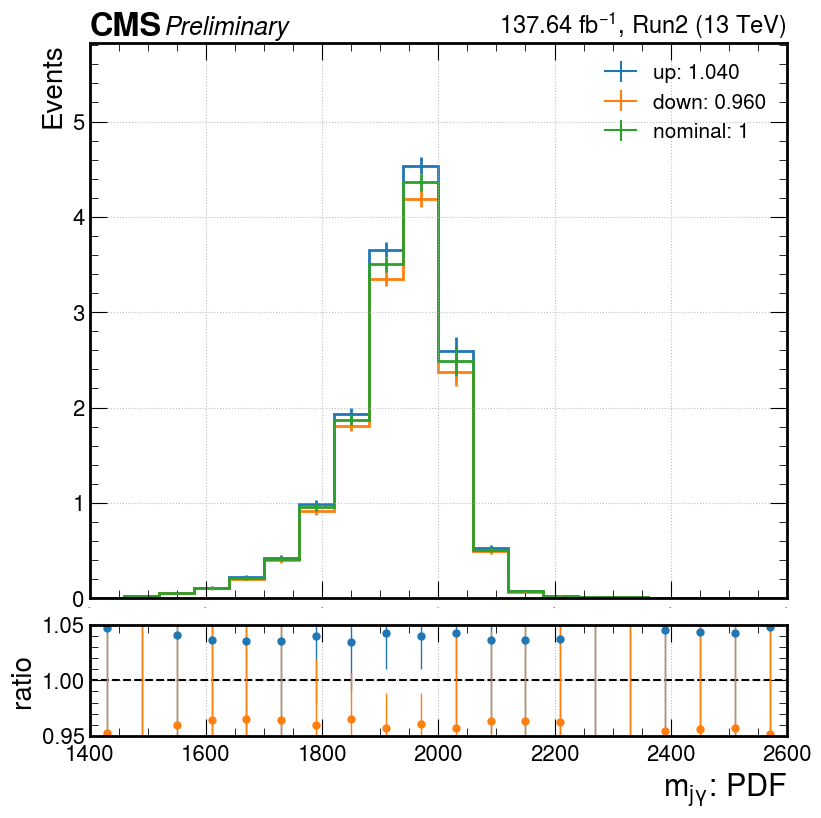

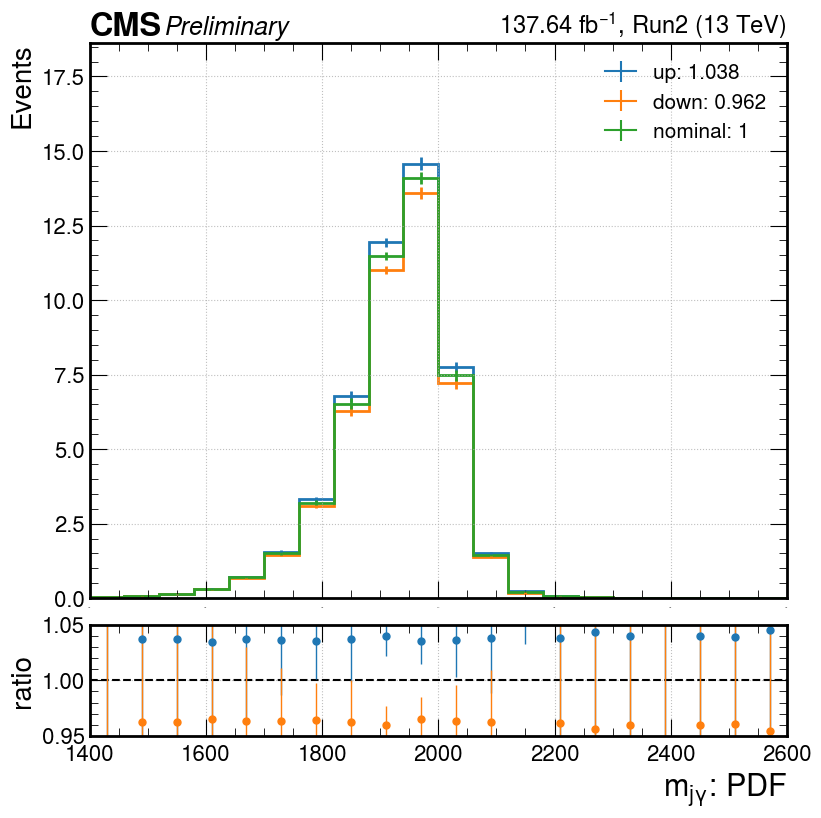

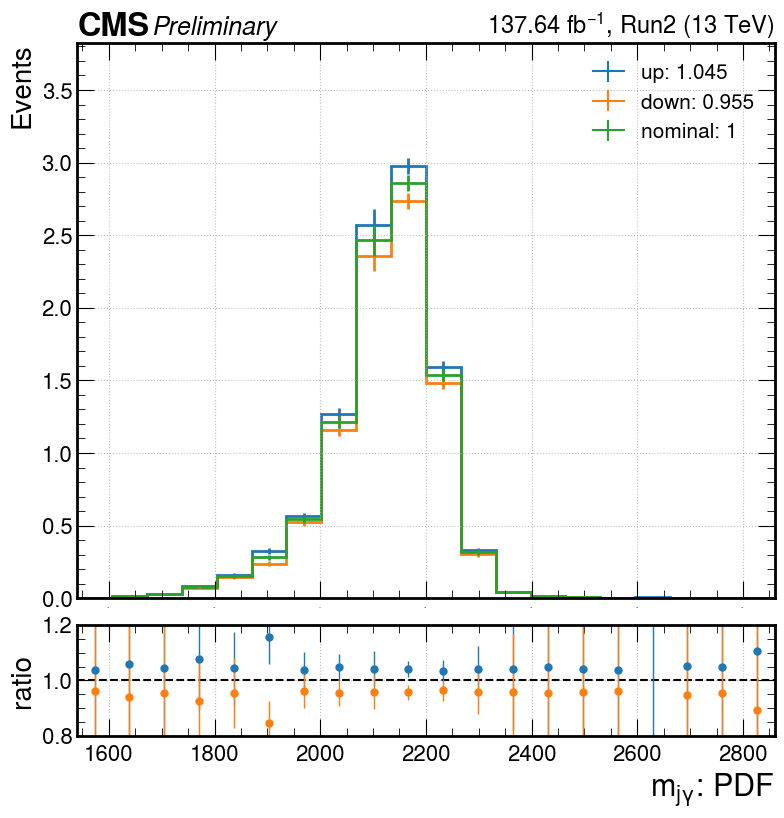

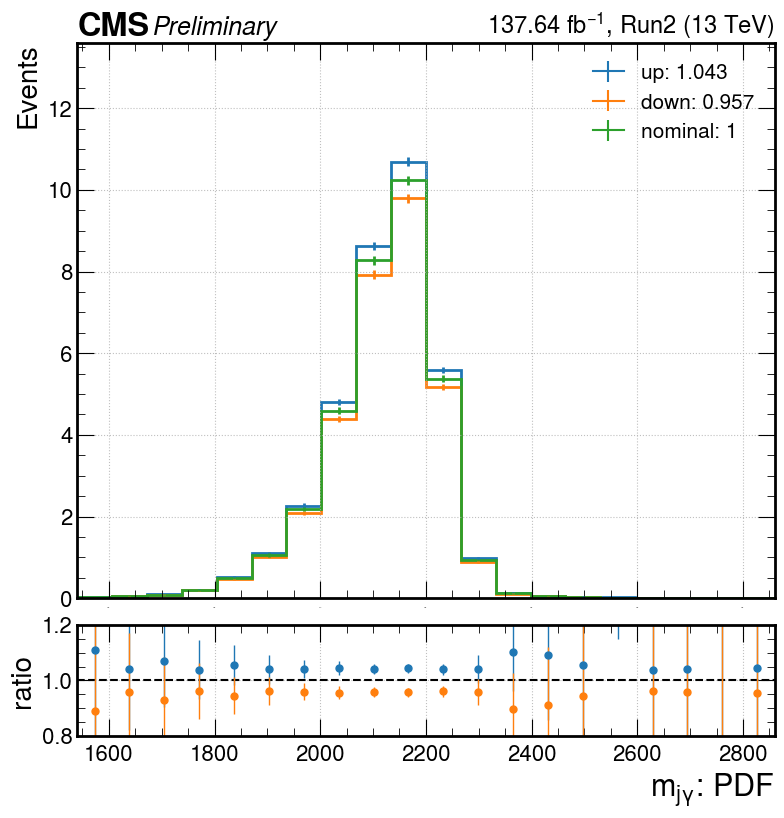

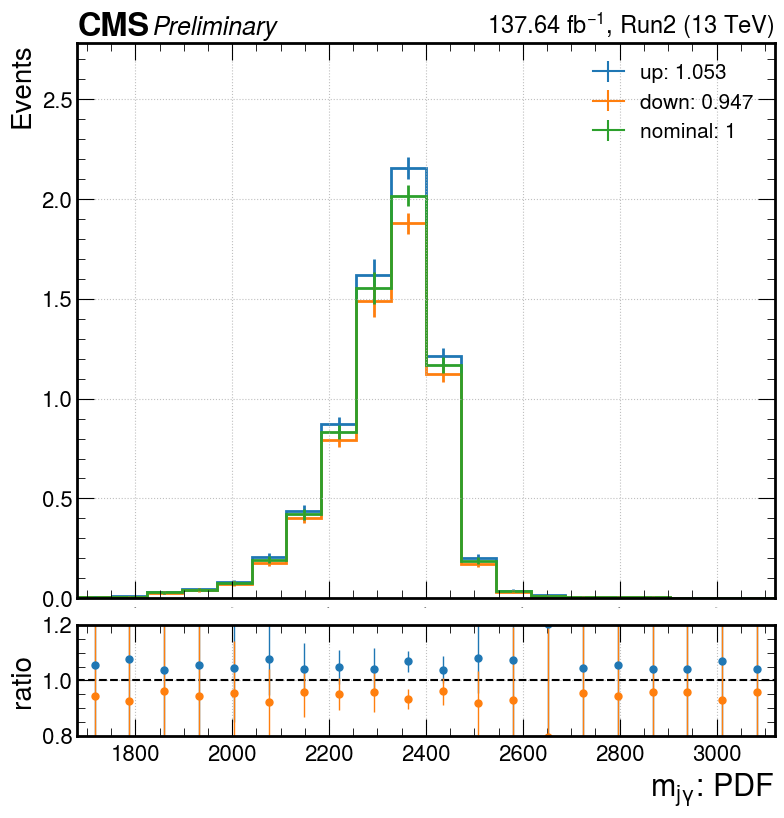

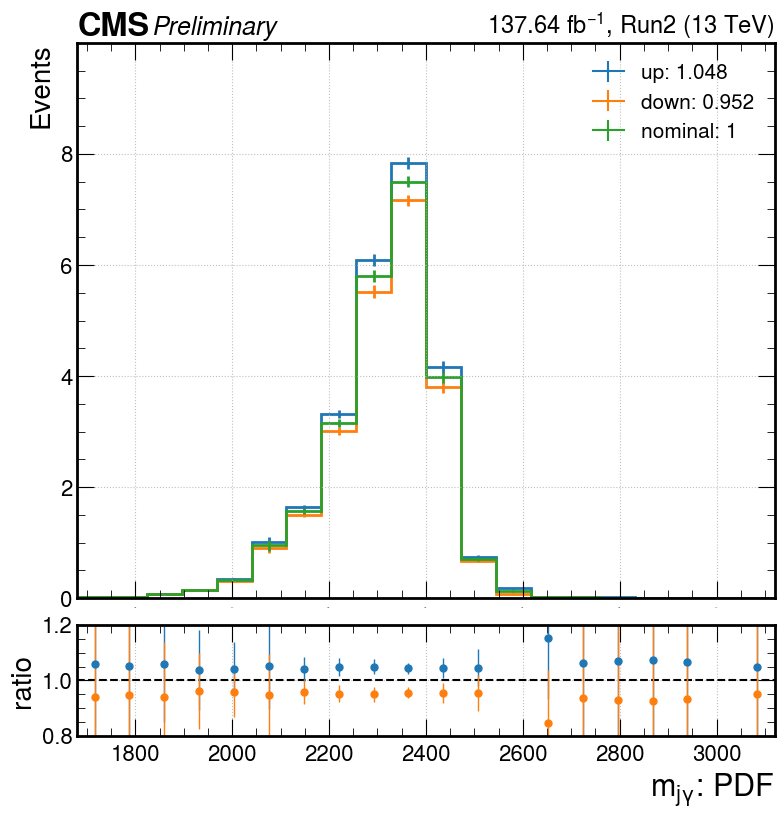

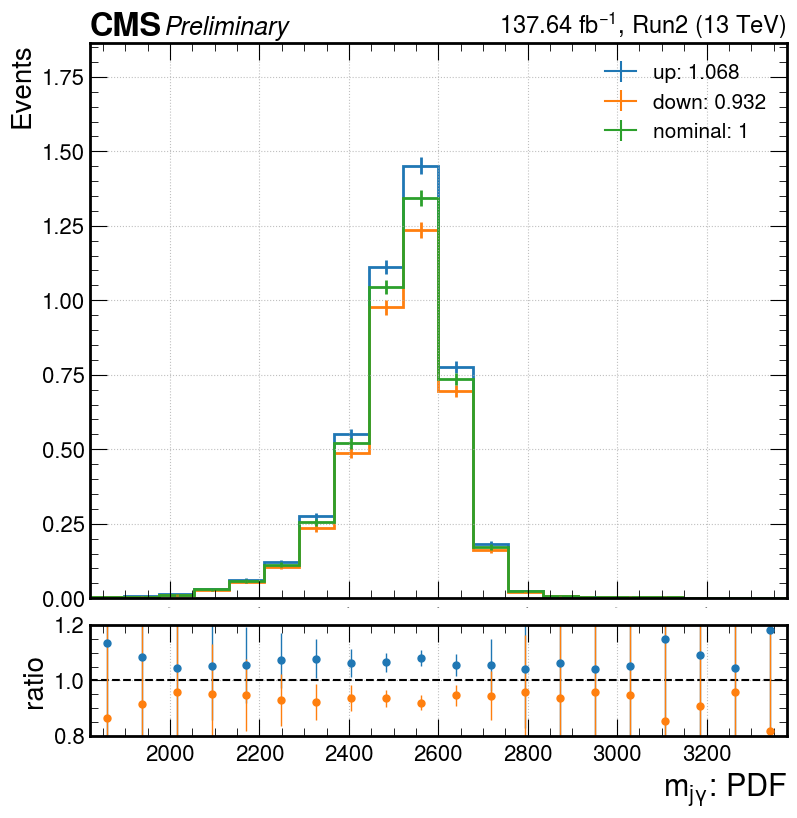

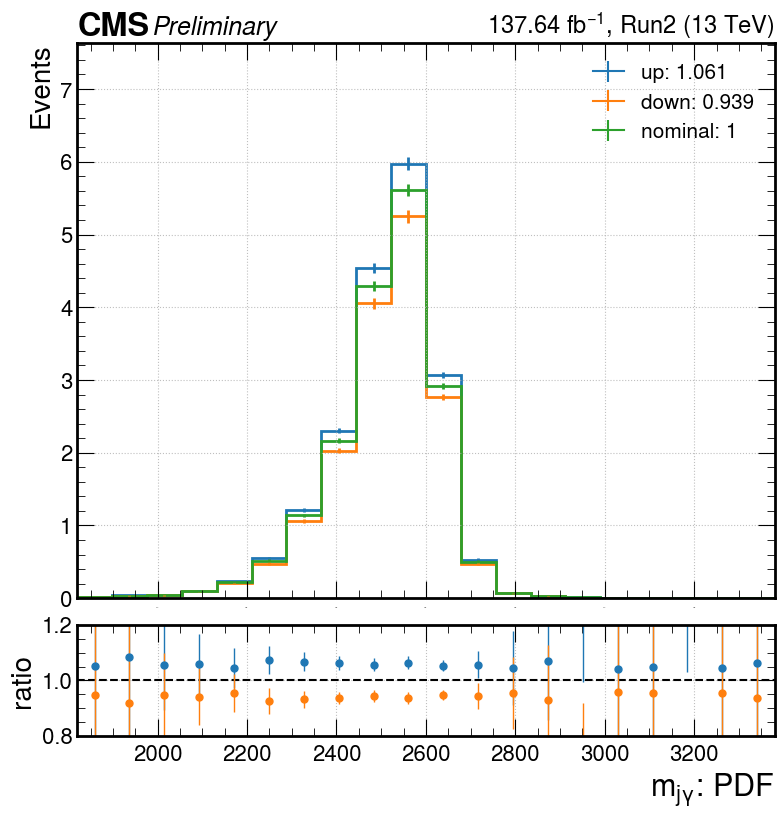

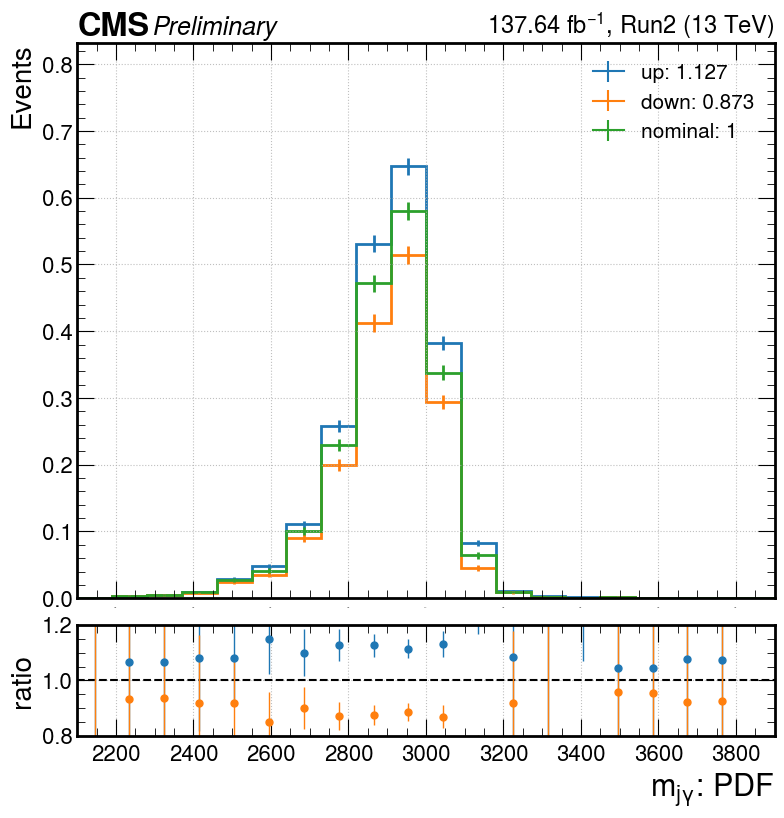

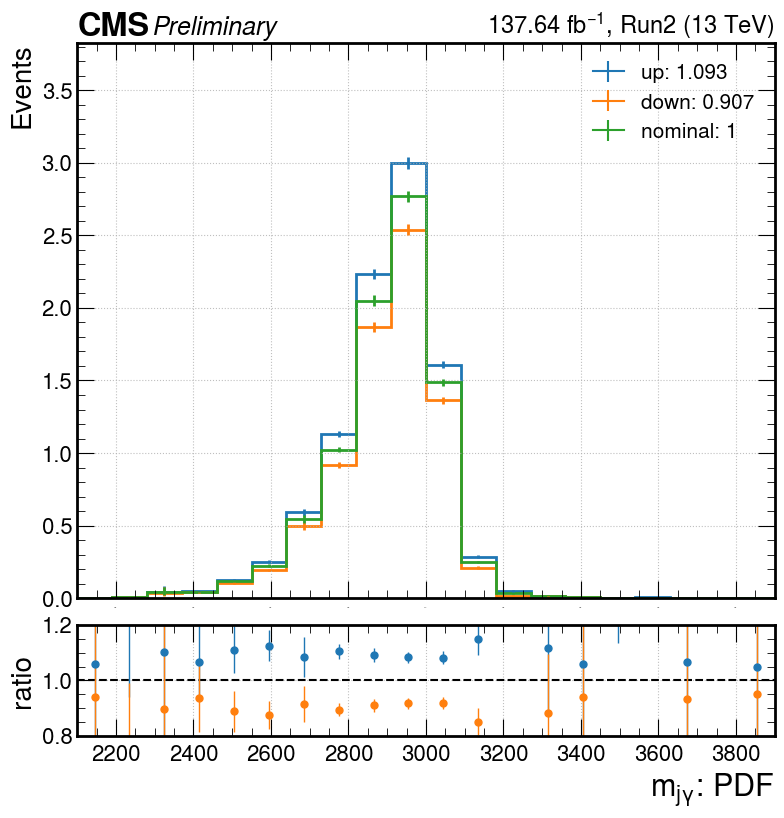

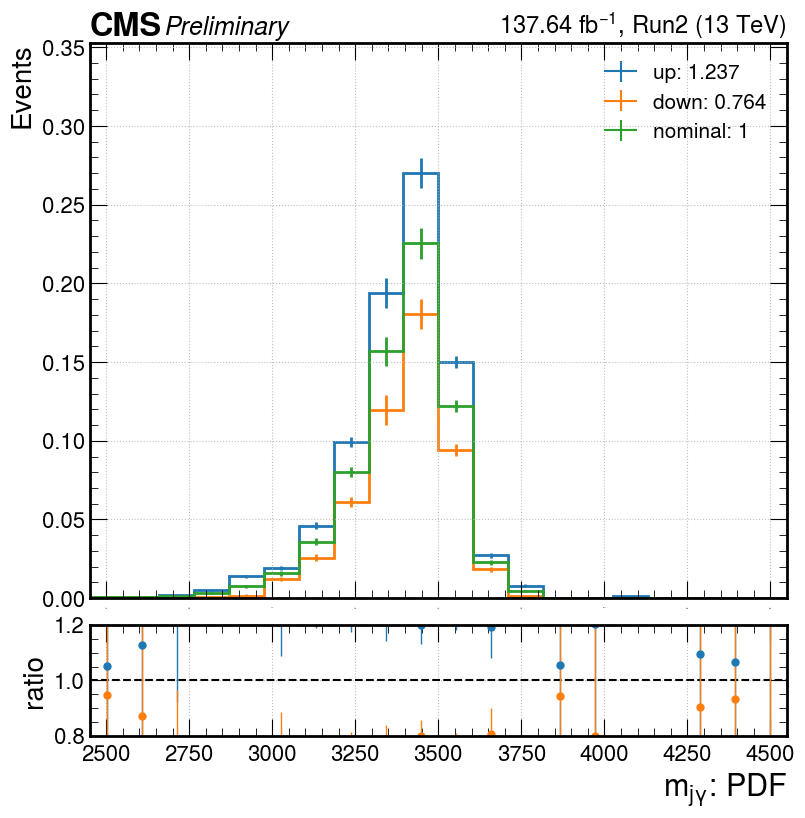

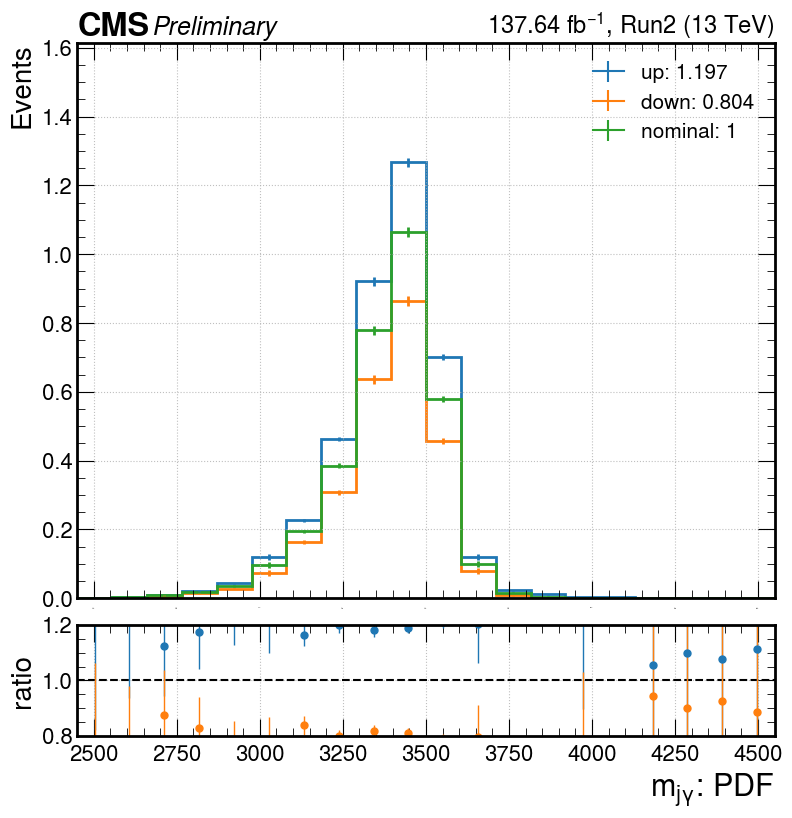

In [10]:
y='Run2'
for m in [700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 3000, 3500]:
    if m > 2000:
        y_min, y_max = 0.8, 1.2
    else:
        y_min, y_max = 0.95, 1.05
    k=r'$Z^\mathrm{\prime}$('+str(m)+r')$\to H(bb)\gamma$'
    # SR1
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (tagger_Hbb[y][k]>0.7) & 
        (tagger_Hbb[y][k]<0.9) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] > 110) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] < 145)
    )"""
    arrays = events[y][k]['photon+jet_mass'][eval(cut)]
    _weight = (weight[y][k]*events[y][k]['LHEPdfWeight'])[eval(cut)]
    pdf_uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: PDF', plot_name=f'PDF_mass_m{m}_SR1', x_min=int(m)*0.7, x_max=int(m)*1.3, bins=20, weight=_weight, year=y, y_min=y_min, y_max=y_max)

    # SR2
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (tagger_Hbb[y][k]>0.9) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] > 110) & 
        (events[y][k]['AK8jet_inclParTMDV1_mass'] < 145)
    )"""
    arrays = events[y][k]['photon+jet_mass'][eval(cut)]
    _weight = (weight[y][k]*events[y][k]['LHEPdfWeight'])[eval(cut)]
    pdf_uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: PDF', plot_name=f'PDF_mass_m{m}_SR2', x_min=int(m)*0.7, x_max=int(m)*1.3, bins=20, weight=_weight, year=y, y_min=y_min, y_max=y_max)

## Trigger Efficiency

In [8]:
SIG_COLOR = {
    #r'700$\to$H(bb)$\gamma$': 'cyan',
    r'1000$\to$H(bb)$\gamma$': 'red',
    #r'1000$\to$Z(bb)$\gamma$': 'blue',
    #r'2000$\to$H(bb)$\gamma$': 'blue',
    #r'2000$\to$Z(bb)$\gamma$': 'cyan',
    r'3000$\to$H(bb)$\gamma$': 'yellow',
    #r'3000$\to$Z(bb)$\gamma$': 'BlueViolet',
}

hep.style.use("CMS")

def trigger_efficiency_plot(arrays, triggered, weight, plot_name: str, x_name: str, year='Run2', bins=40, x_min=0, x_max=2000, density=False, overflow=True, underflow=False, x_axis=None, bin_width=None):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))
    if bin_width is not None:
        bins = (x_max - x_min) // bin_width

    ## canvas initializing
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0.1)
    ax, ax1 = f.add_subplot(gs[0]), f.add_subplot(gs[1])
    ax.grid(); ax1.grid()
    hep.cms.label(data=False, year=year, ax=ax, lumi=round(LUMI[year], 1), fontsize=18, llabel='Preliminary')

    ## analyze
    histogram = {'raw':{}, 'triggered': {}}
    h_err = {'raw':{}, 'triggered': {}}
    efficiency = {}
    eff_err = {}
    ratio_err = {}

    for (k, v) in arrays.items():
        for mode in ('raw', 'triggered'):
            if x_axis is None:
                hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
            else:
                hist = bh.Histogram(x_axis, storage=bh.storage.Weight())

            v = (v if mode=='raw' else v[triggered[k]==1])
            w = (weight[k] if mode=='raw' else weight[k][triggered[k]==1])
            hist.fill(v, weight=w)
            h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
            histogram[mode][k] = h
            h_err[mode][k] = error_bar(histogram[mode][k], var, mode=('data' if k=='data' else 'mc'))

    eff_err_custom = {}
    for k in histogram['raw']:
        efficiency[k] = histogram['triggered'][k]/histogram['raw'][k]
        eff_err[k] = h_err['raw'][k] / histogram['raw'][k]
        eff_err_custom[k] = np.copy(eff_err[k])
        eff_err_custom[k][1] = np.min([1-efficiency[k], eff_err_custom[k][1]], axis=0)

    ## plot
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    #COLOR = {'nominal': 'blue', 'up': 'red', 'down': 'green'}
    for (k, eff) in efficiency.items():
        if k != 'data':
            hep.histplot(eff, bins=hist.axes[0].edges, xerr=True, yerr=eff_err[k], label=k, histtype='errorbar', density=density, markersize=5, stack=False, linewidth=2, ax=ax, capsize=4)
            ratio = efficiency['data']/eff
            ratio_err[k] = ratio * np.sqrt((eff_err['data']/efficiency['data'])**2+(eff_err[k]/eff)**2)
            hep.histplot(ratio, bins=hist.axes[0].edges, xerr=True, yerr=ratio_err[k], label=k, histtype='errorbar', markersize=5, density=density, stack=False, linewidth=2, ax=ax1, capsize=4)
        else:
            hep.histplot(eff, bins=hist.axes[0].edges, xerr=True, yerr=eff_err[k], label=k, histtype='errorbar', density=density, markersize=10, stack=False, linewidth=2, ax=ax, color='black', capsize=4)
    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, 1.2)
    ax.set_xticklabels([])
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    # x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    # y_major_locator=MultipleLocator(1)
    # ax.xaxis.set_major_locator(x_major_locator)
    # ax.yaxis.set_major_locator(y_major_locator)
    ax.set_ylabel(r'$\varepsilon_{trigger}$', fontsize=22, ha='right', y=1)
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_xlabel(x_name, fontsize=20, ha='right', x=1)
    ax1.set_ylim(0.5, 1.5)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_ylabel(r'SF=$\frac{\varepsilon(data)}{\varepsilon(MC)}$', fontsize=22, ha='right', y=1)

    ## title, text and legend
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)

    ## finalizing
    if not os.path.exists(f'./plots/{year}'):
        os.makedirs(f'./plots/{year}')
    plt.savefig(f"./plots/{year}/{plot_name}.pdf", bbox_inches='tight')
    plt.show()
    
    return ratio_err

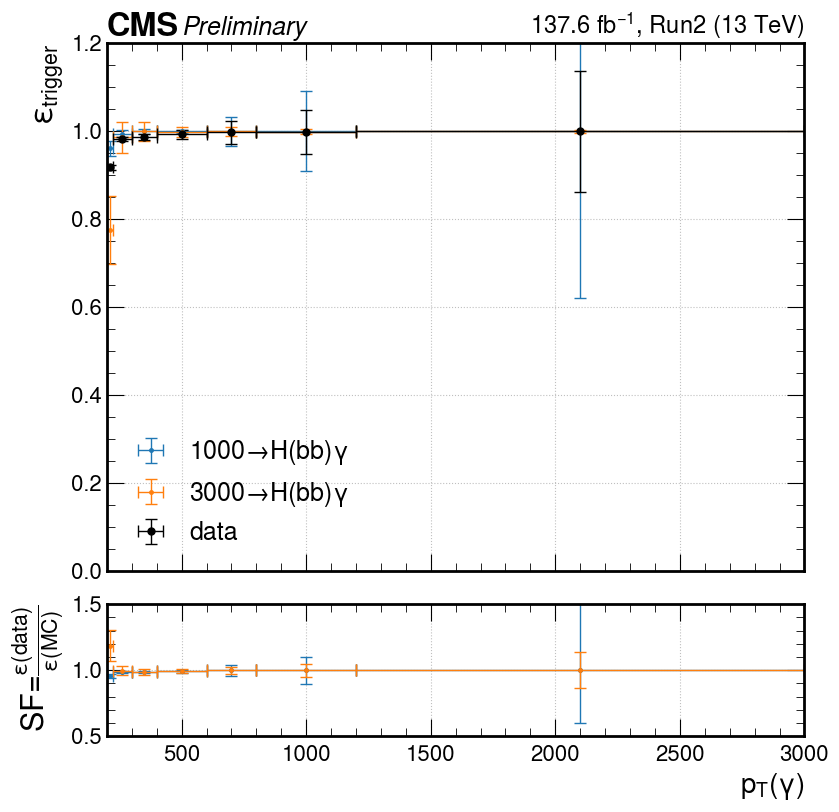

{'1000$\\to$H(bb)$\\gamma$': array([[0.01740064, 0.00930589, 0.00917749, 0.01158593, 0.04202813,
         0.10421852, 0.40273635],
        [0.01740064, 0.00930589, 0.00917749, 0.01158593, 0.04202813,
         0.10421852, 0.575628  ]]),
 '3000$\\to$H(bb)$\\gamma$': array([[0.11847132, 0.03618368, 0.02324862, 0.01608171, 0.02823821,
         0.05018725, 0.13746052],
        [0.11847132, 0.03618368, 0.02324862, 0.01608171, 0.02823821,
         0.05018725, 0.13746052]])}

In [9]:
y = 'Run2'
arrays = {}
triggered = {}
for k in list(SIG_COLOR.keys())+['data']:
    arrays[k] = events[y][k]['photon_pt']
    if k == 'data':
        triggered[k] = events[y][k]['triggered'] | (np.abs(events[y][k]['photon_eta'])<1.4442)
    else:
        triggered[k] = events[y][k]['triggered'] | ((np.abs(events[y][k]['photon_eta'])<1.9) & (events[y][k]['photon_pt']<225))

SF_err = trigger_efficiency_plot(arrays, triggered, x_name=r'$p_T(\gamma)$', plot_name=f'trigger_efficiency', weight=weight[y], x_axis=bh.axis.Variable([200, 225, 300, 400, 600, 800, 1200, 3000]), x_min=200, x_max=3000, year=y, underflow=False, overflow=True)
SF_err


In [131]:
SF_err['1000$\\to$H(bb)$\\gamma$'][0]

array([0.01740064, 0.00930589, 0.00917749, 0.01158593, 0.03833023])

In [ ]:
SF_err